/tmp/ipykernel_3293709/1588949912.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['downscale'] = filtered_data['downscale'].str.replace('d', '.').astype(float)
/tmp/ipykernel_3293709/1588949912.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['combined_identifier'] = filtered_data['downscale'].astype(str) + "_" + filtered_data['alpha']
/tmp/ipykernel_3293709/1588949912.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results 

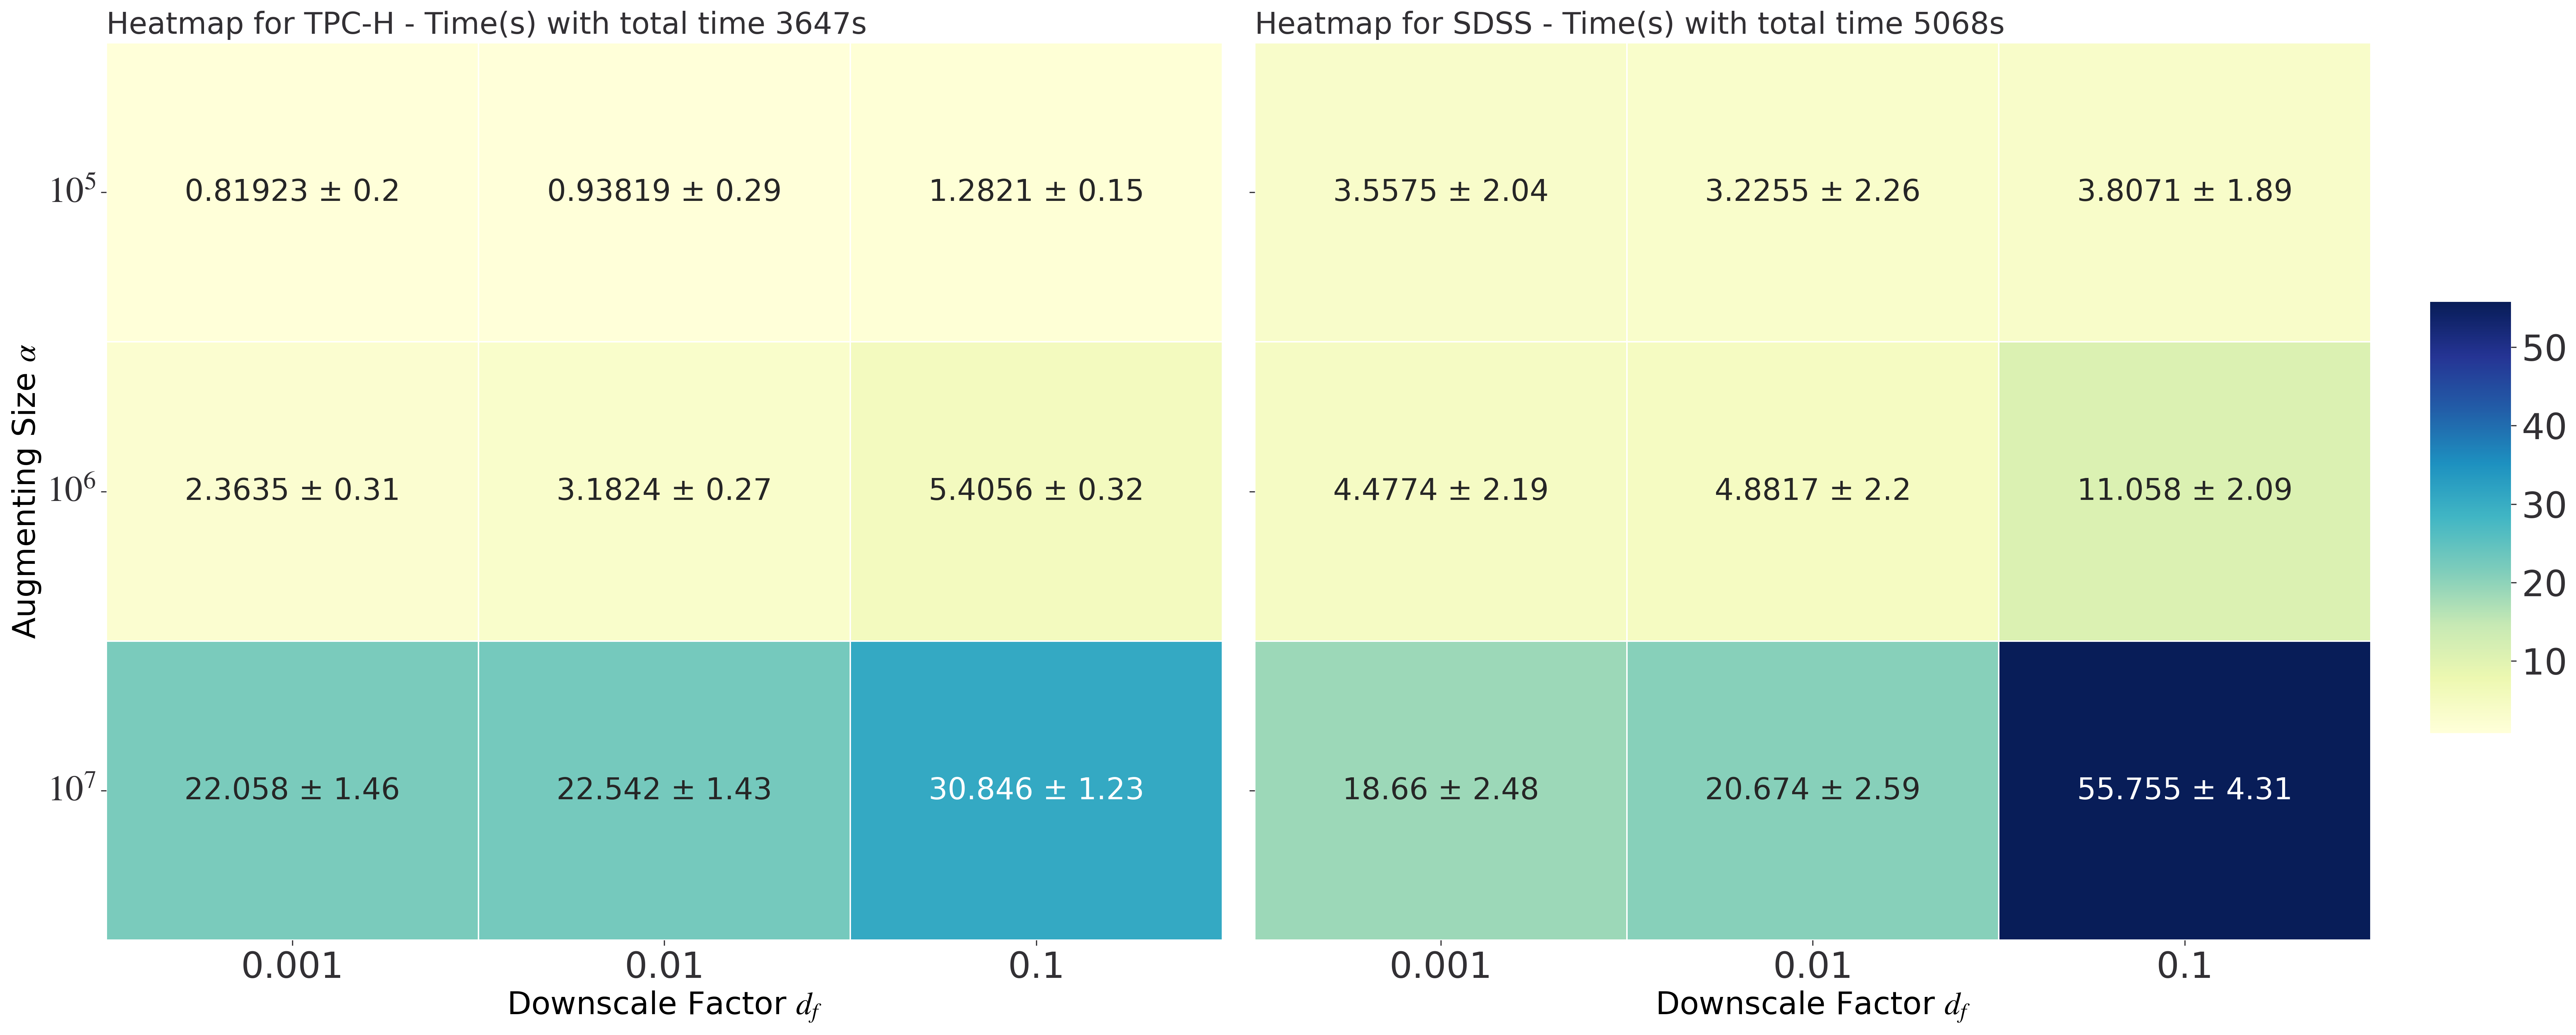

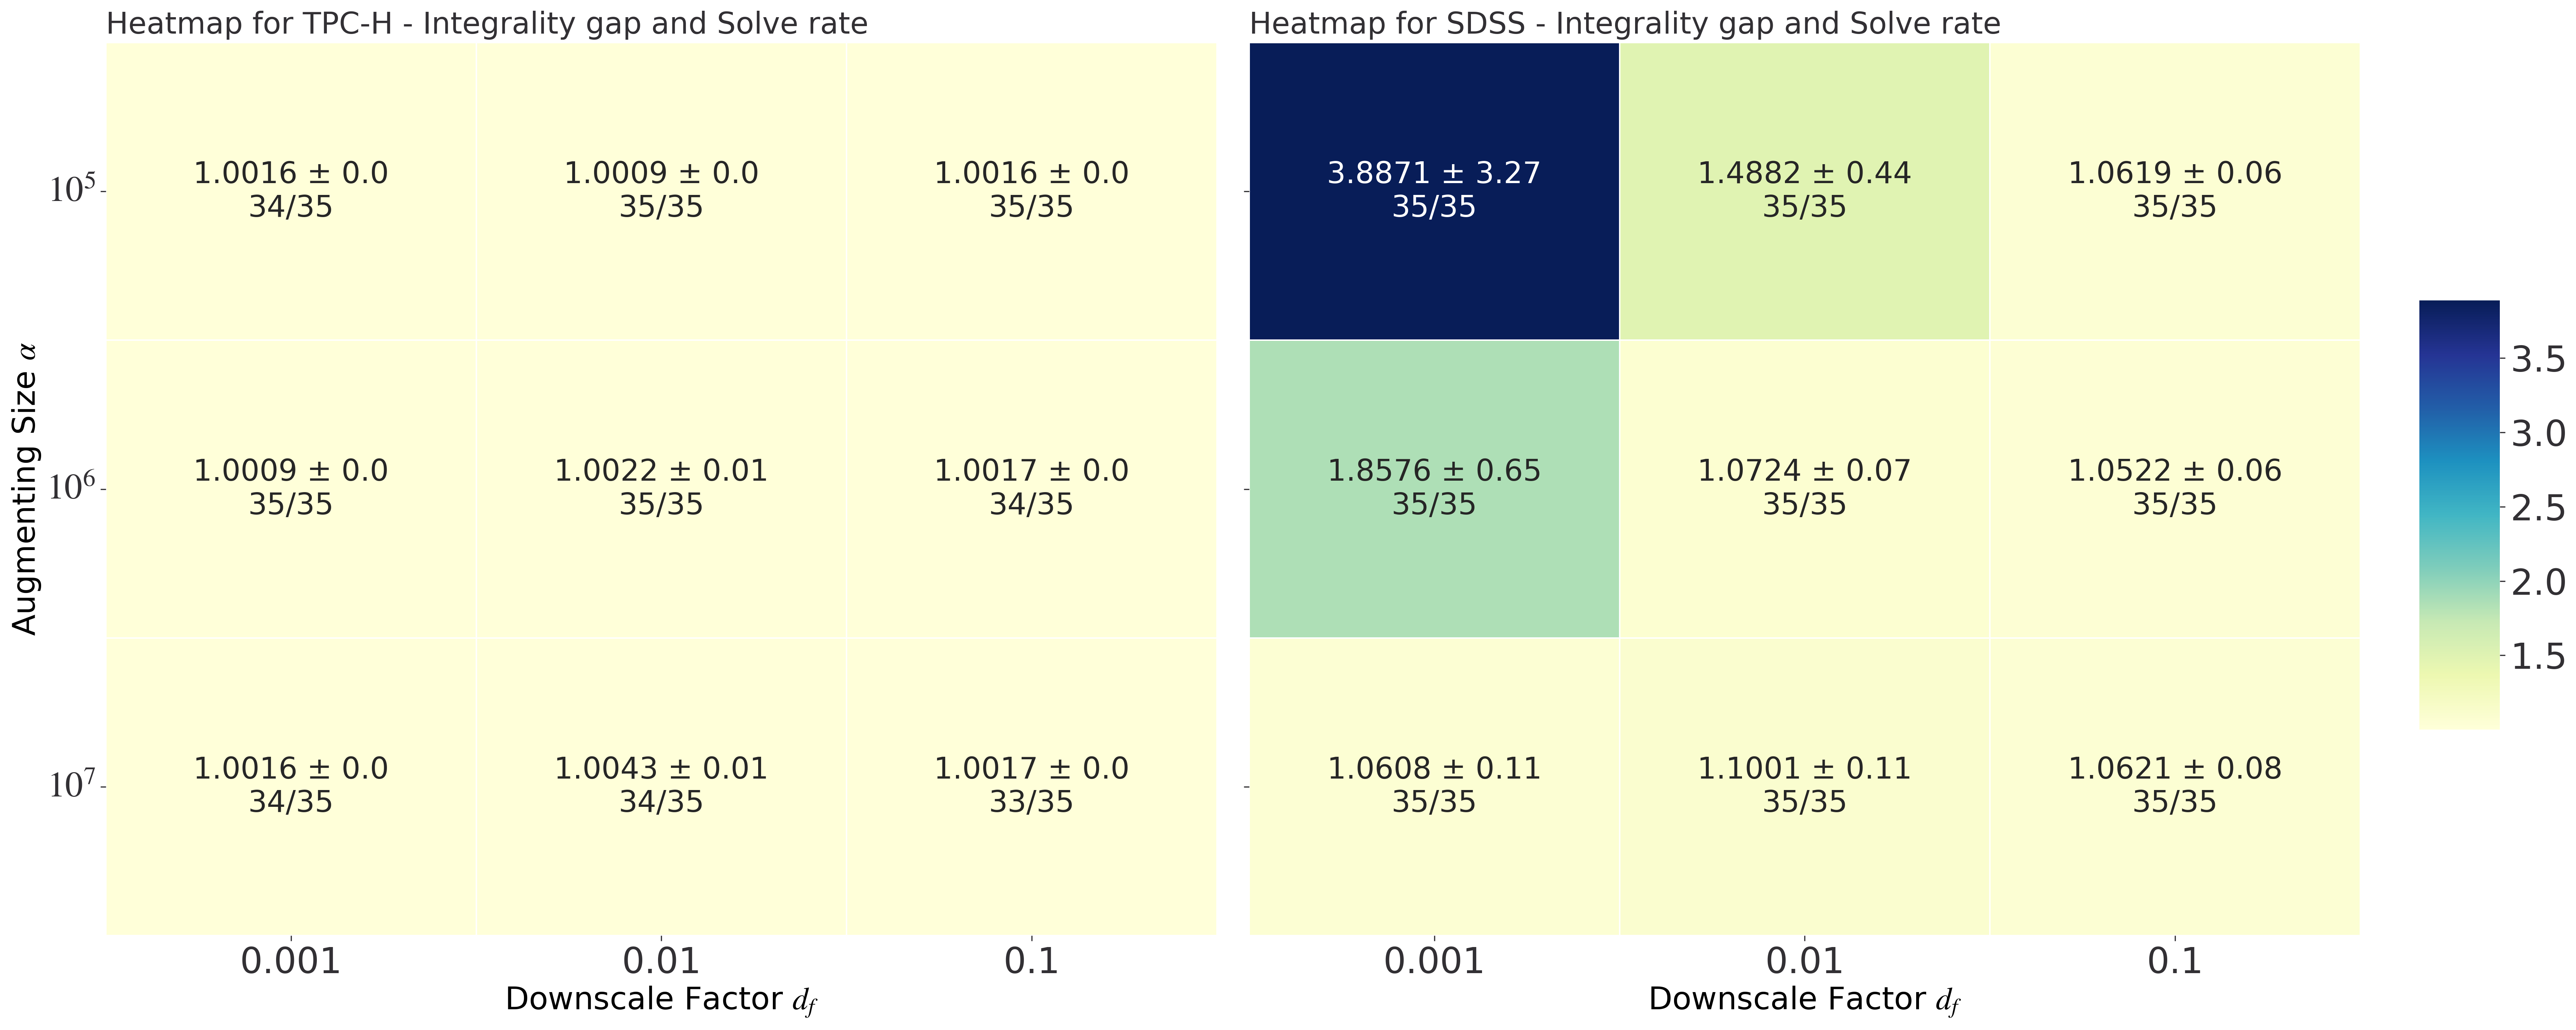

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 8
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data with varying number of columns
data_list = []
ssds_total_time = 0
tpch_total_time = 0
with open("G1.csv", 'r') as file:
    for line in file:
        data_list.append(line.strip().split(','))
        if "time" in line:
            if "ssds" in line:
                ssds_total_time += float(data_list[-1][-1])
            if "tpch" in line:
                tpch_total_time += float(data_list[-1][-1])
                
ssds_total_time = int(ssds_total_time/1000)
tpch_total_time = int(tpch_total_time/1000)

# Convert to DataFrame
data_df = pd.DataFrame(data_list).T

# Extracting columns from the loaded data
labels = data_df.iloc[0, 1:].values
hardness_values = data_df.iloc[1, 1:].values
measurement_values = data_df.iloc[2, 1:].values

# Create structured DataFrame
structured_data = pd.DataFrame({
    'label': labels,
    'hardness': hardness_values,
    'measurement': measurement_values
})

# Splitting the 'label' column into separate columns
structured_data['dataset_name'] = structured_data['label'].str.split('_').str[0]
structured_data['downscale'] = structured_data['label'].str.split('_').str[1].str[2:]
structured_data['alpha'] = structured_data['label'].str.split('_').str[2].str[5:]
structured_data['measurement_type'] = structured_data['label'].str.split('_').str[3]

# Convert columns to appropriate data types
structured_data['hardness'] = structured_data['hardness'].astype(float)
structured_data['measurement'] = structured_data['measurement'].astype(float)

# Filter out unwanted measurement types
filtered_data = structured_data[structured_data['measurement_type'].isin(['time', 'ptime', 'igap', 'found', 'nofound'])]

# Correct 'downscale' values
filtered_data['downscale'] = filtered_data['downscale'].str.replace('d', '.').astype(float)
filtered_data['combined_identifier'] = filtered_data['downscale'].astype(str) + "_" + filtered_data['alpha']

# Aggregate data for heatmaps
agg_data_std = filtered_data.groupby(['dataset_name', 'downscale', 'alpha', 'measurement_type']).agg({
    'measurement': ['mean', 'std']
}).reset_index()
agg_data_std.columns = ['dataset_name', 'downscale', 'alpha', 'measurement_type', 'mean_measurement', 'std_measurement']

# Convert 'time' measurements to seconds and format all values to 5 significant figures
agg_data_std.loc[agg_data_std['measurement_type'] == 'time', 'mean_measurement'] /= 1000
agg_data_std.loc[agg_data_std['measurement_type'] == 'time', 'std_measurement'] /= 1000
agg_data_std['mean_measurement'] = agg_data_std['mean_measurement'].apply(lambda x: '{:.5g}'.format(x)).astype(float)
agg_data_std['std_measurement'] = agg_data_std['std_measurement'].apply(lambda x: '{:.5g}'.format(x)).astype(float)

# Calculate the number of solved problems and total problems for each combination of alpha and df
solved_problems = filtered_data[filtered_data['measurement_type'] == 'found'].groupby(['dataset_name', 'downscale', 'alpha']).agg({'measurement': 'sum'}).rename(columns={'measurement': 'solved'})
total_problems = filtered_data[filtered_data['measurement_type'].isin(['found', 'nofound'])].groupby(['dataset_name', 'downscale', 'alpha']).agg({'measurement': 'sum'}).rename(columns={'measurement': 'total'})

# Merge the data to have both solved and total problems in one DataFrame
problems_data = pd.merge(solved_problems, total_problems, on=['dataset_name', 'downscale', 'alpha']).reset_index()
problems_data['solved_ratio'] = problems_data['solved'].astype(int).astype(str) + "/" + problems_data['total'].astype(int).astype(str)

# Function to plot heatmaps with a truly shared color scale and standard deviation
def plot_corrected_shared_heatmap(measurement_type, measurement_name, data, is_igap=False):
    palette = "YlGnBu"
    fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    # Determine global color scale limits for the measurement type
    vmin = data[data['measurement_type'] == measurement_type]['mean_measurement'].min()
    vmax = data[data['measurement_type'] == measurement_type]['mean_measurement'].max()
    
    dataset_names = ["TPC-H", "SDSS"]
    total_times = [tpch_total_time, ssds_total_time]
    
    for i, (ax, dataset) in enumerate(zip(axes, datasets)):
        subset = data[(data['dataset_name'] == dataset) & (data['measurement_type'] == measurement_type)]
        heatmap_data = subset.pivot('alpha', 'downscale', 'mean_measurement')
        std_data = subset.pivot('alpha', 'downscale', 'std_measurement')
        
        if is_igap:
            solved_subset = problems_data[problems_data['dataset_name'] == dataset]
            solved_info = solved_subset.pivot('alpha', 'downscale', 'solved_ratio')
            annot = np.array(np.array(heatmap_data.astype(str) + " ± " + std_data.round(2).astype(str)) + "\n" + solved_info)
            ax.set_title(f"Heatmap for {dataset_names[i]} - {measurement_name}")
        else:
            annot = np.array(np.array(heatmap_data.astype(str) + " ± " + std_data.round(2).astype(str)))
            ax.set_title(f"Heatmap for {dataset_names[i]} - {measurement_name} with total time {total_times[i]}s")
        
        sns.heatmap(heatmap_data, cmap=palette, annot=annot, fmt="", linewidths=.5, ax=ax, cbar_ax=cbar_ax,
                    vmin=vmin, vmax=vmax)
        ax.set_xlabel(r"Downscale Factor $d_f$")
        
        # Correctly update y-labels using LaTeX formatting
        y_labels = [r'$10^{' + str(int(np.log10(float(label)))) + '}$' for label in heatmap_data.index]
        ax.set_yticklabels(y_labels, rotation=0)
        
    axes[0].set_ylabel(r"Augmenting Size $\alpha$")
    axes[1].set_ylabel("")
    plt.tight_layout(rect=[0, 0, .9, 1])
    plt.show()

datasets = filtered_data['dataset_name'].unique()

# Generate the shared heatmaps with corrected color scales
plot_corrected_shared_heatmap('time', "Time(s)", agg_data_std)
plot_corrected_shared_heatmap('igap', "Integrality gap and Solve rate", agg_data_std, True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_3293709/4031489131.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


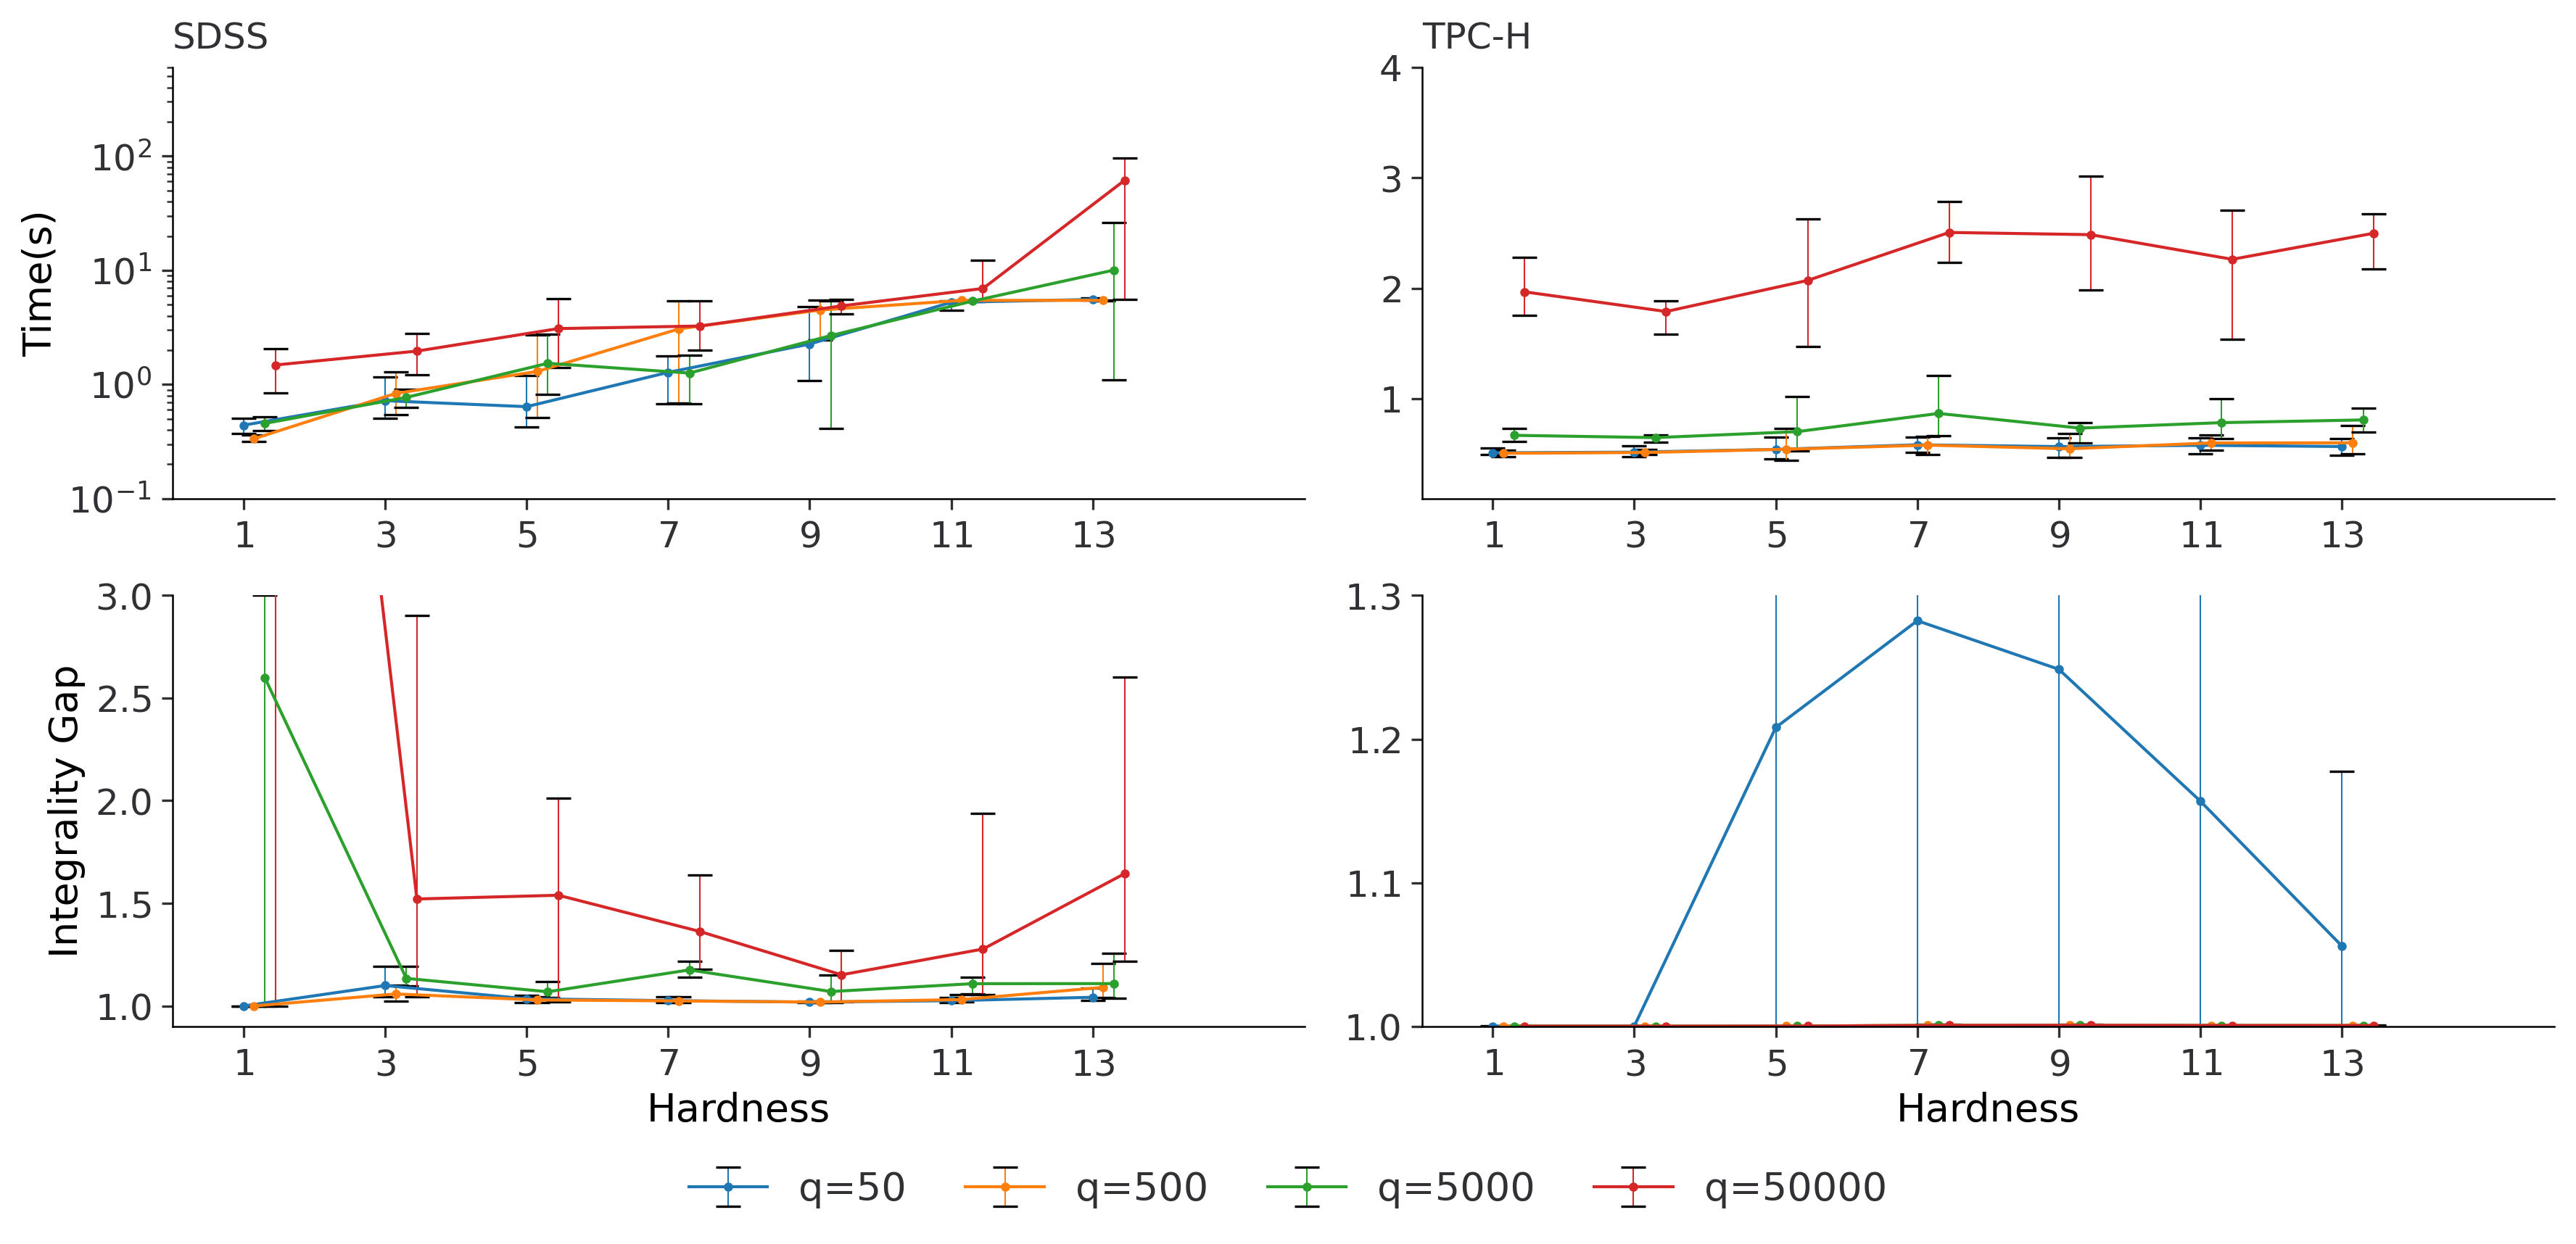

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('G2.csv', header=None)
data.columns = ["label", "hardness", "measurement_value"]

# Split label into dataset, Q value, and measurement type
data['dataset'] = data['label'].apply(lambda x: x.split('_')[0])
data['q'] = data['label'].apply(lambda x: x.split('_')[1][1:])
data['measurement_type'] = data['label'].apply(lambda x: x.split('_')[2])

# Filter for 'time' and 'igap' measurement types
filtered_data = data[data['measurement_type'].isin(['time', 'igap', 'found', 'nofound'])]
filtered_data.loc[filtered_data['measurement_type'] == 'time', 'measurement_value'] /= 1000

# Group by dataset, Q value, measurement type, and hardness to compute mean and std
grouped_data = filtered_data.groupby(['dataset', 'q', 'measurement_type', 'hardness'])
sum_values = grouped_data['measurement_value'].sum().reset_index()
mean_values = grouped_data['measurement_value'].mean().reset_index()
min_values = grouped_data['measurement_value'].min().reset_index()
max_values = grouped_data['measurement_value'].max().reset_index()

# # Merge mean and std dataframes
aggregated_data = pd.merge(sum_values, mean_values, on=['dataset', 'q', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, min_values, on=['dataset', 'q', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, max_values, on=['dataset', 'q', 'measurement_type', 'hardness'])
aggregated_data.columns = ['dataset', 'q', 'measurement_type', 'hardness', 'sum', 'mean', 'min', 'max']
aggregated_data['ypos'] = aggregated_data['max']-aggregated_data['mean']
aggregated_data['yneg'] = aggregated_data['mean']-aggregated_data['min']

# solved_problems = aggregated_data[aggregated_data['measurement_type'] == 'found'].groupby(['dataset', 'q']).agg({'sum': 'sum'}).rename(columns={'sum': 'solved'})
# print(solved_problems)
# # Merge the data to have both solved and total problems in one DataFrame
# problems_data = pd.merge(solved_problems, total_problems, on=['dataset_name', 'downscale', 'alpha']).reset_index()
# problems_data['solved_ratio'] = problems_data['solved'].astype(int).astype(str) + "/" + problems_data['total'].astype(int).astype(str)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
xticks = list(range(1, 14, 2))
dataset = ['ssds', 'tpch']
dataset_names = ['SDSS', 'TPC-H']
qs = ["50", "500", "5000", "50000"]
d = 0.15
xoffset = np.arange(0, 5*d, d)
ylims = [(0.1, 600), (0.1, 4)]
ylimss = [(0.9, 3), (1, 1.3)]

for i, D in enumerate(dataset):
    df_agg = aggregated_data[aggregated_data['dataset']==D]
    ax = axs[0, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['q']==q] 
        time_data = q_data.loc[q_data['measurement_type']=='time']
#         print(time_data)
        ax.errorbar(
            time_data['hardness']+xoffset[j], 
            time_data['mean'], 
            yerr=[time_data['yneg'], time_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    if i == 0:
        ax.set_yscale('log')
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.set_xticks(xticks)
    ax.set_title(dataset_names[i])

    axx = axs[1, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['q']==q] 
        igap_data = q_data.loc[q_data['measurement_type']=='igap']
#         print(time_data)
        axx.errorbar(
            igap_data['hardness']+xoffset[j], 
            igap_data['mean'], 
            yerr=[igap_data['yneg'], igap_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    axx.set_ylim(ylimss[i][0], ylimss[i][1])
    axx.set_xticks(xticks)
    axx.set_xlabel('Hardness')

axs[0, 0].set_ylabel('Time(s)')
axs[1, 0].set_ylabel('Integrality Gap')

# Create a separate axis for the legend at the bottom
ax_leg = fig.add_axes([0.15, 0.05, 0.7, 0.05])
ax_leg.axis('off')

ax_leg.legend(axs[1, 1].get_legend_handles_labels()[0], [f"q={q}" for q in qs], loc='center', ncol=len(qs), frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_3293709/1073598175.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


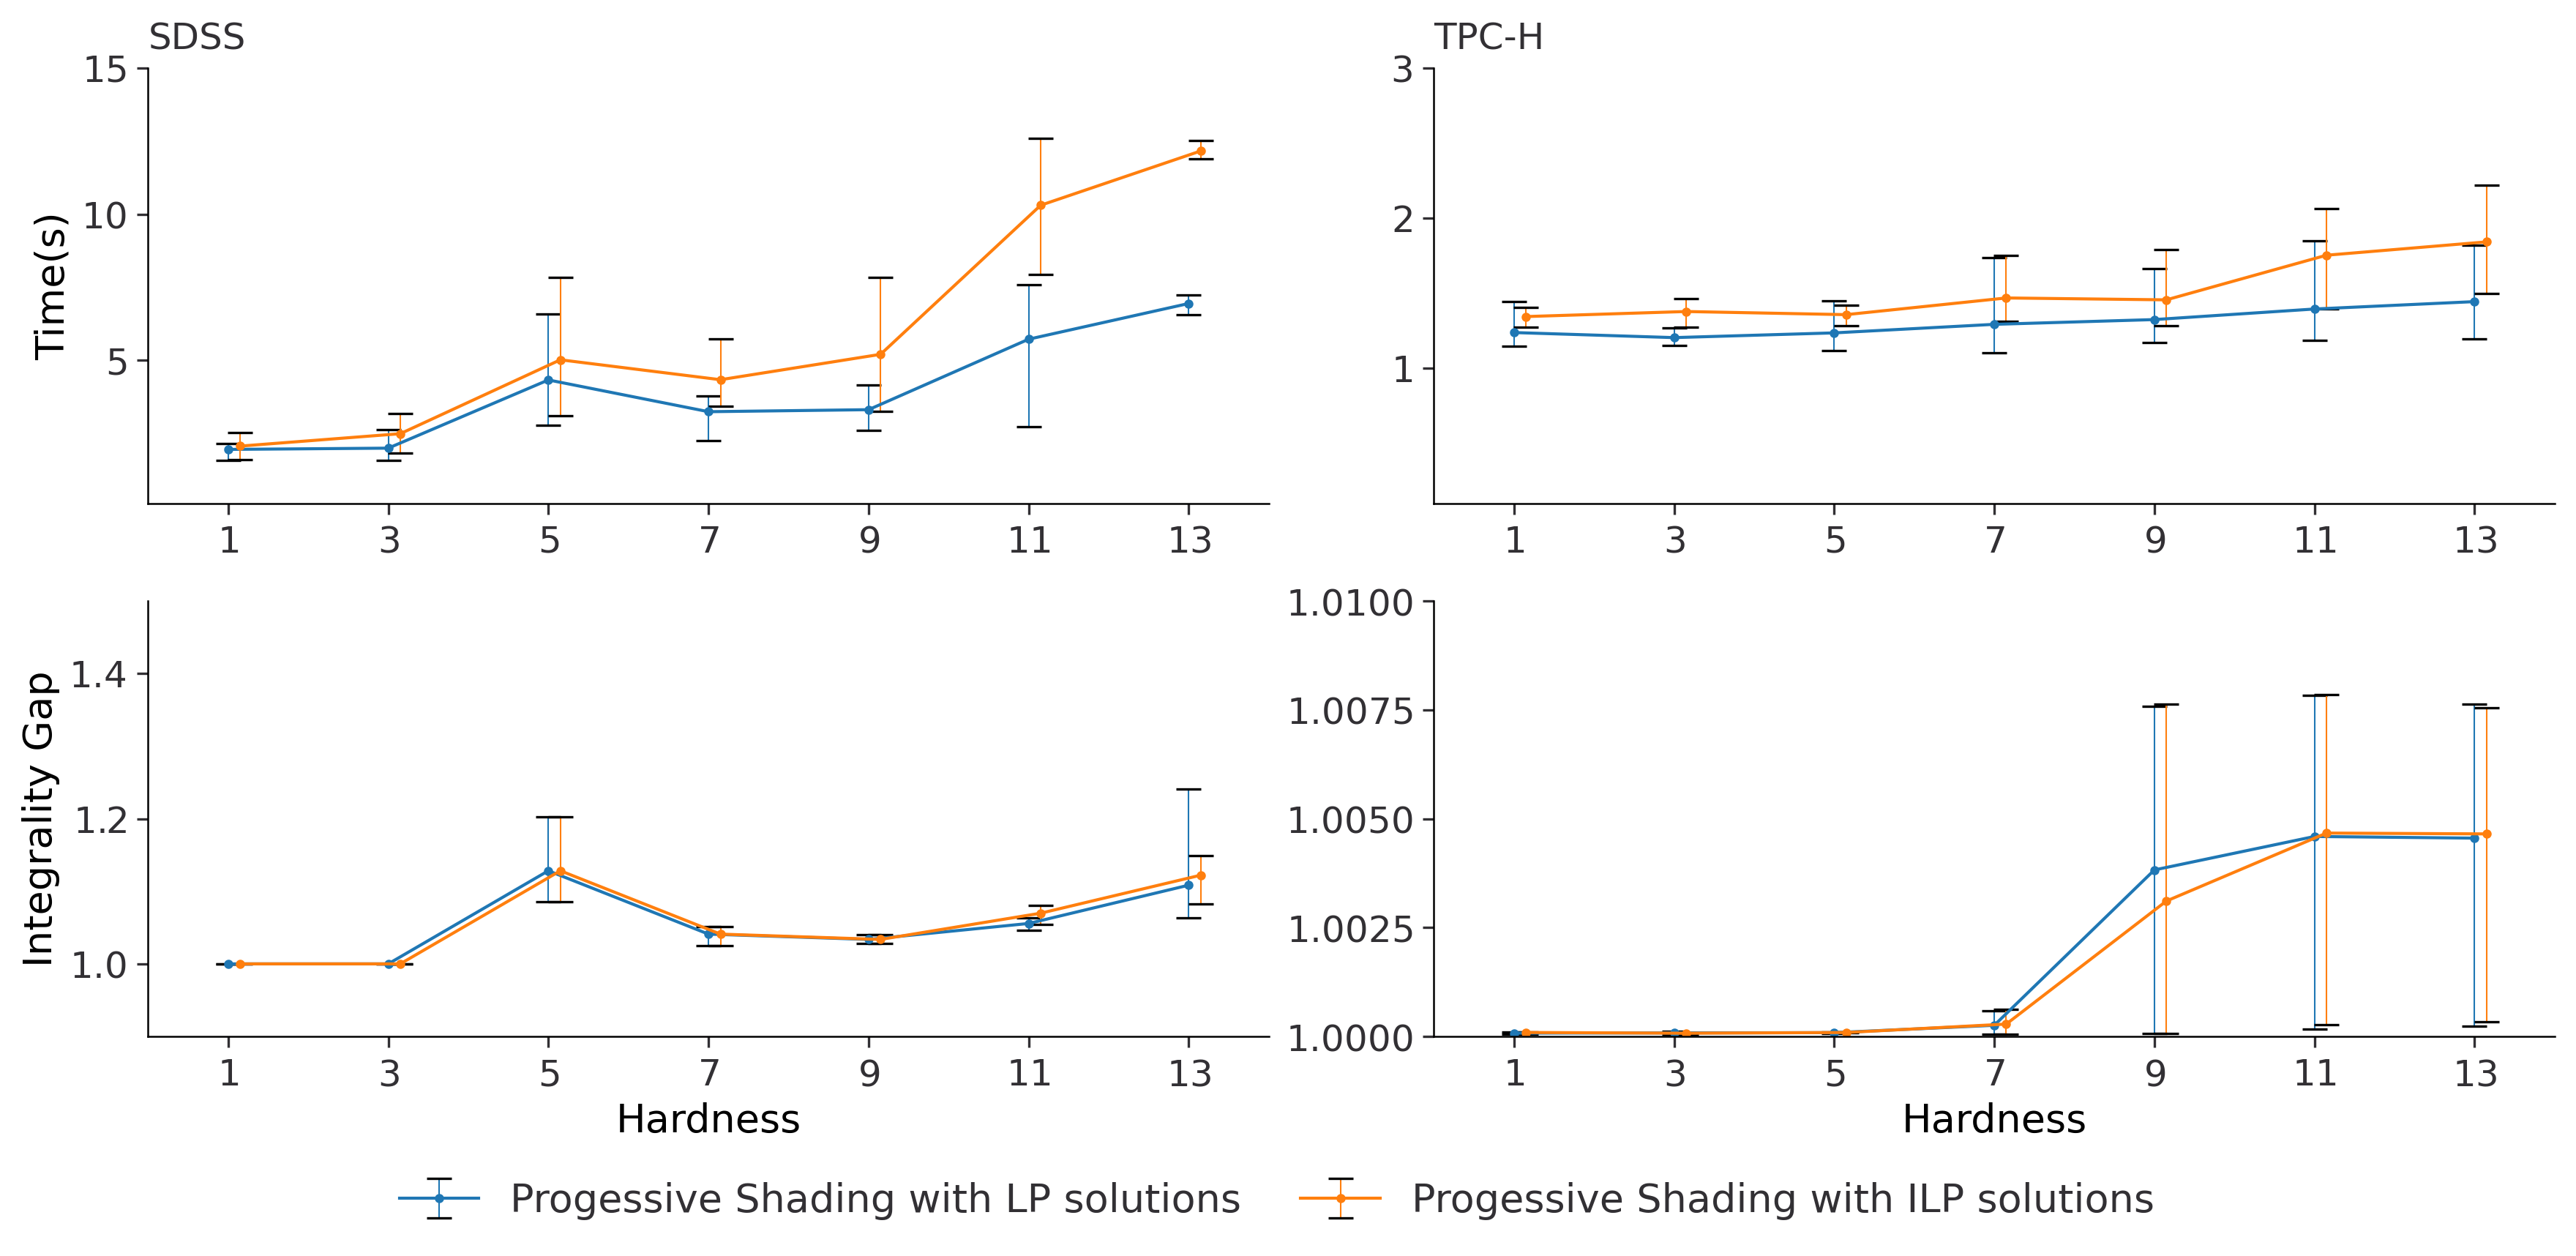

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('M1.csv', header=None)
data.columns = ["label", "hardness", "measurement_value"]

# Split label into dataset, Q value, and measurement type
data['dataset'] = data['label'].apply(lambda x: x.split('_')[0])
data['method'] = data['label'].apply(lambda x: x.split('_')[1])
data['measurement_type'] = data['label'].apply(lambda x: x.split('_')[2])

# Filter for 'time' and 'igap' measurement types
filtered_data = data[data['measurement_type'].isin(['time', 'igap', 'found', 'nofound'])]
filtered_data.loc[filtered_data['measurement_type'] == 'time', 'measurement_value'] /= 1000

# Group by dataset, Q value, measurement type, and hardness to compute mean and std
grouped_data = filtered_data.groupby(['dataset', 'method', 'measurement_type', 'hardness'])
sum_values = grouped_data['measurement_value'].sum().reset_index()
mean_values = grouped_data['measurement_value'].mean().reset_index()
min_values = grouped_data['measurement_value'].min().reset_index()
max_values = grouped_data['measurement_value'].max().reset_index()

# # Merge mean and std dataframes
aggregated_data = pd.merge(sum_values, mean_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, min_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, max_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data.columns = ['dataset', 'method', 'measurement_type', 'hardness', 'sum', 'mean', 'min', 'max']
aggregated_data['ypos'] = aggregated_data['max']-aggregated_data['mean']
aggregated_data['yneg'] = aggregated_data['mean']-aggregated_data['min']

# solved_problems = aggregated_data[aggregated_data['measurement_type'] == 'found'].groupby(['dataset', 'q']).agg({'sum': 'sum'}).rename(columns={'sum': 'solved'})
# print(solved_problems)
# # Merge the data to have both solved and total problems in one DataFrame
# problems_data = pd.merge(solved_problems, total_problems, on=['dataset_name', 'downscale', 'alpha']).reset_index()
# problems_data['solved_ratio'] = problems_data['solved'].astype(int).astype(str) + "/" + problems_data['total'].astype(int).astype(str)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
xticks = list(range(1, 14, 2))
dataset = ['ssds', 'tpch']
dataset_names = ['SDSS', 'TPC-H']
qs = ["LPLSR", "ILPLSR"]
d = 0.15
xoffset = np.arange(0, 5*d, d)
ylims = [(0.1, 15), (0.1, 3)]
ylimss = [(0.9, 1.5), (1, 1.01)]

for i, D in enumerate(dataset):
    df_agg = aggregated_data[aggregated_data['dataset']==D]
    ax = axs[0, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        time_data = q_data.loc[q_data['measurement_type']=='time']
#         print(time_data)
        ax.errorbar(
            time_data['hardness']+xoffset[j], 
            time_data['mean'], 
            yerr=[time_data['yneg'], time_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.set_xticks(xticks)
    ax.set_title(dataset_names[i])

    axx = axs[1, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        igap_data = q_data.loc[q_data['measurement_type']=='igap']
#         print(time_data)
        axx.errorbar(
            igap_data['hardness']+xoffset[j], 
            igap_data['mean'], 
            yerr=[igap_data['yneg'], igap_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    axx.set_ylim(ylimss[i][0], ylimss[i][1])
    axx.set_xticks(xticks)
    axx.set_xlabel('Hardness')

axs[0, 0].set_ylabel('Time(s)')
axs[1, 0].set_ylabel('Integrality Gap')

# Create a separate axis for the legend at the bottom
ax_leg = fig.add_axes([0.15, 0.05, 0.7, 0.05])
ax_leg.axis('off')

legends = ["Progessive Shading with LP solutions", "Progessive Shading with ILP solutions"]

ax_leg.legend(axs[1, 1].get_legend_handles_labels()[0], [f"{legends[i]}" for i in range(len(qs))], loc='center', ncol=len(qs), frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_3293709/3830192692.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


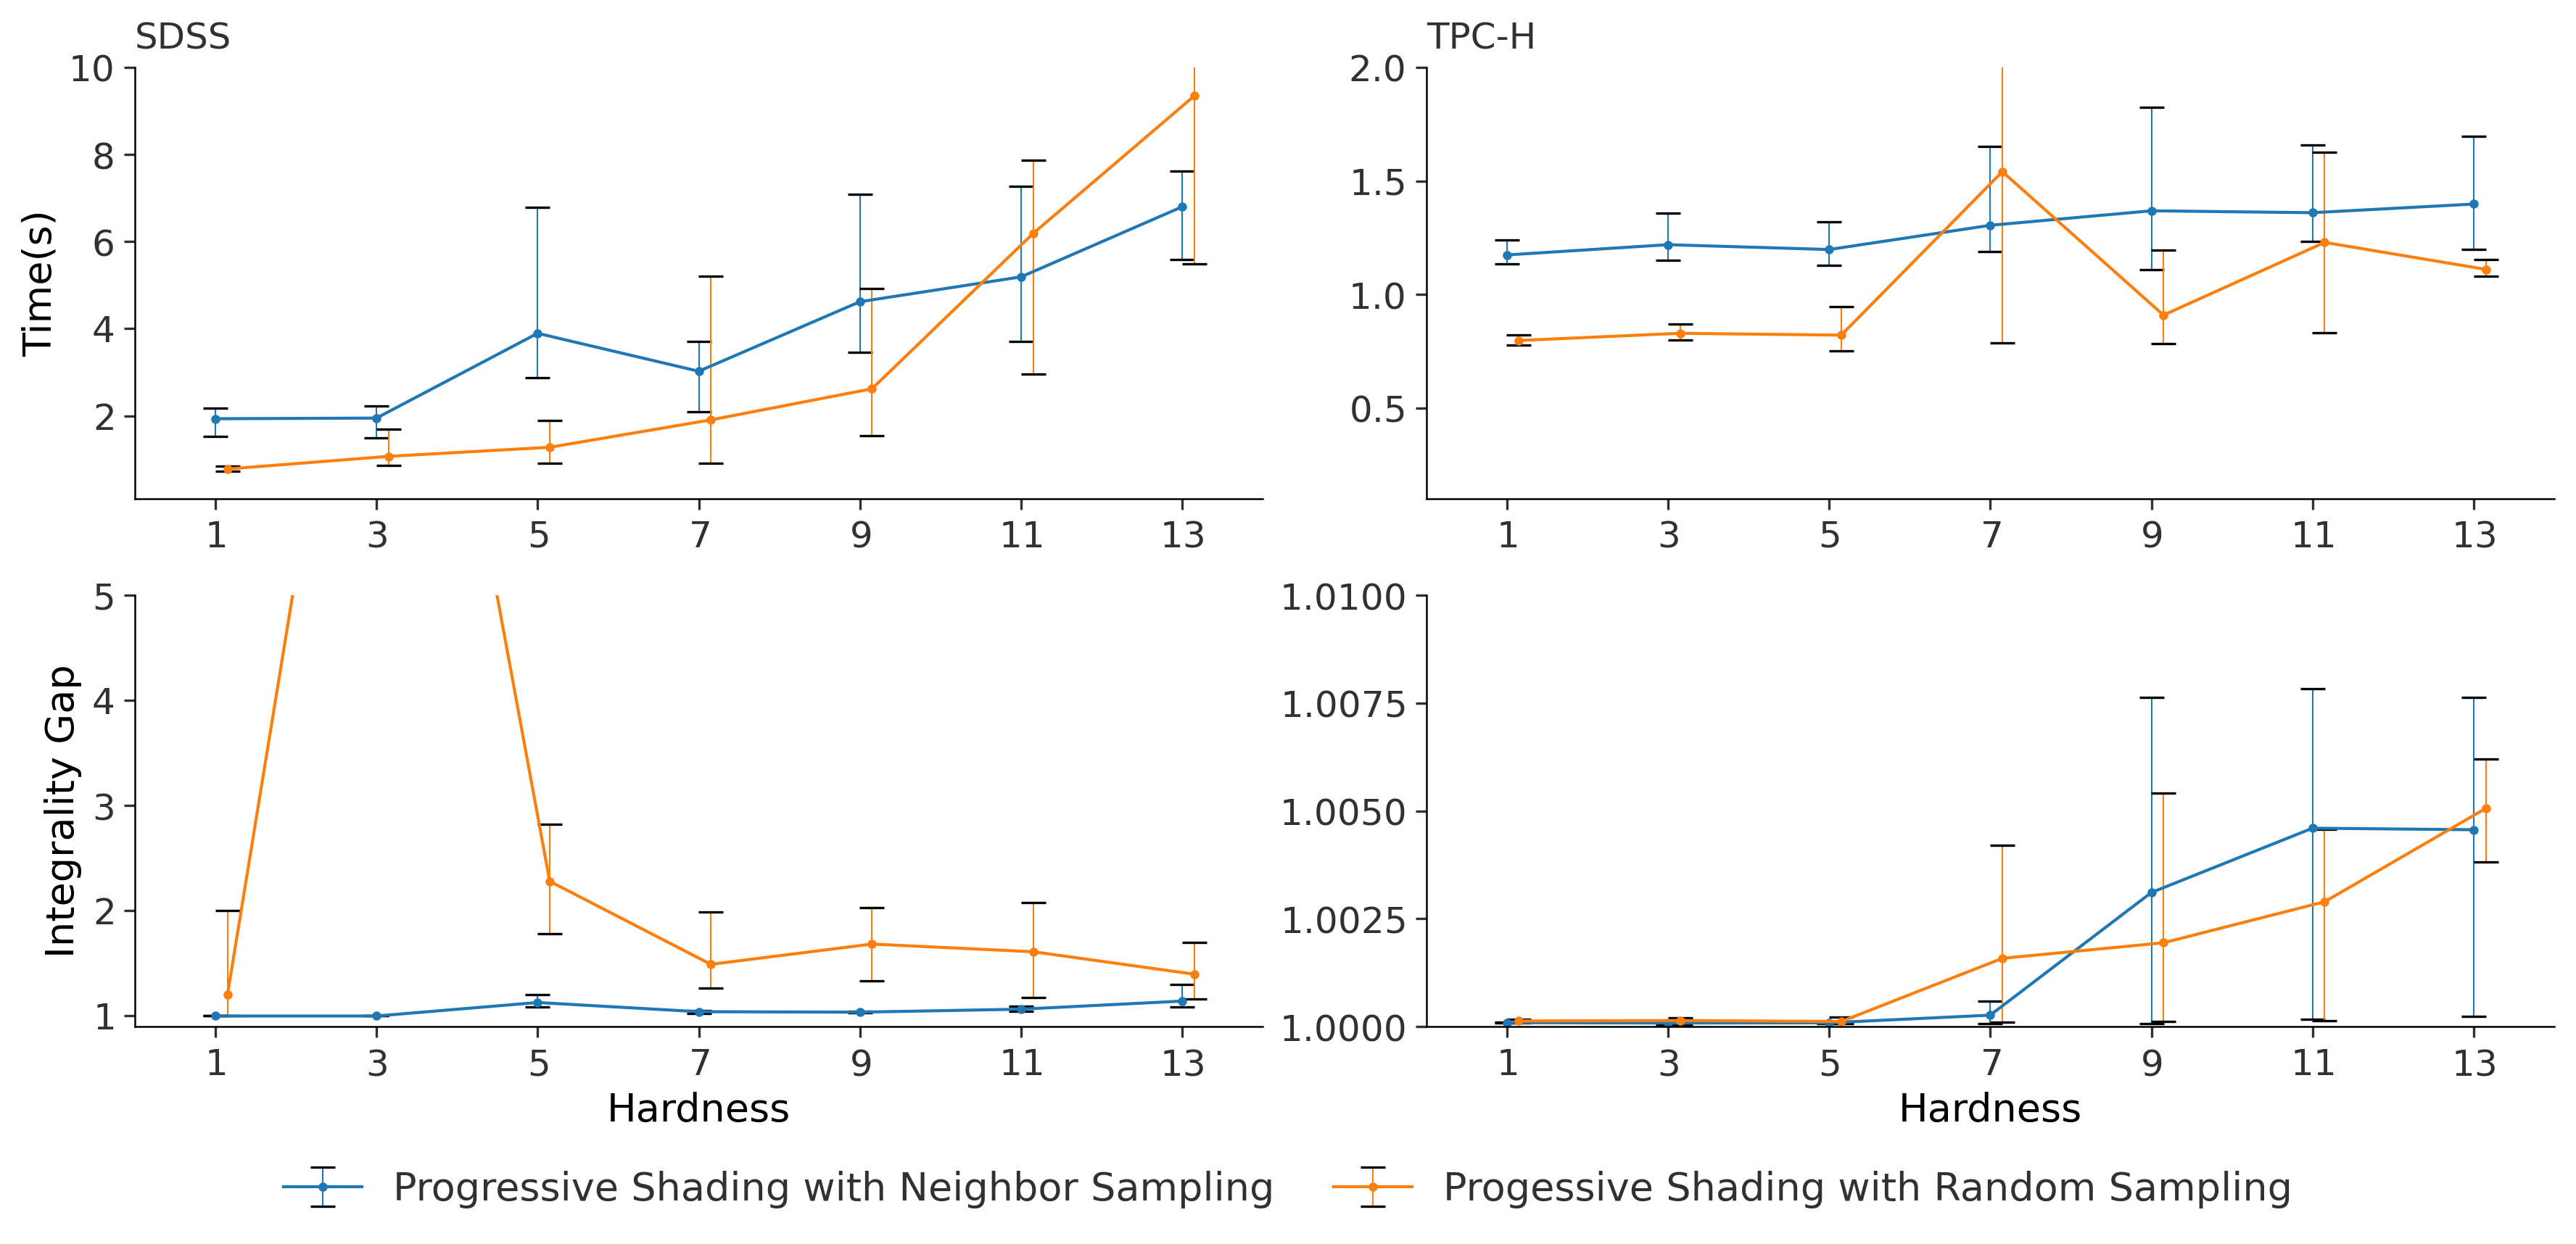

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('M2.csv', header=None)
data.columns = ["label", "hardness", "measurement_value"]

# Split label into dataset, Q value, and measurement type
data['dataset'] = data['label'].apply(lambda x: x.split('_')[0])
data['method'] = data['label'].apply(lambda x: x.split('_')[1])
data['measurement_type'] = data['label'].apply(lambda x: x.split('_')[2])

# Filter for 'time' and 'igap' measurement types
filtered_data = data[data['measurement_type'].isin(['time', 'igap', 'found', 'nofound'])]
filtered_data.loc[filtered_data['measurement_type'] == 'time', 'measurement_value'] /= 1000

# Group by dataset, Q value, measurement type, and hardness to compute mean and std
grouped_data = filtered_data.groupby(['dataset', 'method', 'measurement_type', 'hardness'])
sum_values = grouped_data['measurement_value'].sum().reset_index()
mean_values = grouped_data['measurement_value'].mean().reset_index()
min_values = grouped_data['measurement_value'].min().reset_index()
max_values = grouped_data['measurement_value'].max().reset_index()

# # Merge mean and std dataframes
aggregated_data = pd.merge(sum_values, mean_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, min_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, max_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data.columns = ['dataset', 'method', 'measurement_type', 'hardness', 'sum', 'mean', 'min', 'max']
aggregated_data['ypos'] = aggregated_data['max']-aggregated_data['mean']
aggregated_data['yneg'] = aggregated_data['mean']-aggregated_data['min']

# solved_problems = aggregated_data[aggregated_data['measurement_type'] == 'found'].groupby(['dataset', 'q']).agg({'sum': 'sum'}).rename(columns={'sum': 'solved'})
# print(solved_problems)
# # Merge the data to have both solved and total problems in one DataFrame
# problems_data = pd.merge(solved_problems, total_problems, on=['dataset_name', 'downscale', 'alpha']).reset_index()
# problems_data['solved_ratio'] = problems_data['solved'].astype(int).astype(str) + "/" + problems_data['total'].astype(int).astype(str)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
xticks = list(range(1, 14, 2))
dataset = ['ssds', 'tpch']
dataset_names = ['SDSS', 'TPC-H']
qs = ["LSR", "RLSR"]
d = 0.15
xoffset = np.arange(0, 5*d, d)
ylims = [(0.1, 10), (0.1, 2)]
ylimss = [(0.9, 5), (1, 1.01)]

for i, D in enumerate(dataset):
    df_agg = aggregated_data[aggregated_data['dataset']==D]
    ax = axs[0, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        time_data = q_data.loc[q_data['measurement_type']=='time']
#         print(time_data)
        ax.errorbar(
            time_data['hardness']+xoffset[j], 
            time_data['mean'], 
            yerr=[time_data['yneg'], time_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.set_xticks(xticks)
    ax.set_title(dataset_names[i])

    axx = axs[1, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        igap_data = q_data.loc[q_data['measurement_type']=='igap']
#         print(time_data)
        axx.errorbar(
            igap_data['hardness']+xoffset[j], 
            igap_data['mean'], 
            yerr=[igap_data['yneg'], igap_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    axx.set_ylim(ylimss[i][0], ylimss[i][1])
    axx.set_xticks(xticks)
    axx.set_xlabel('Hardness')

axs[0, 0].set_ylabel('Time(s)')
axs[1, 0].set_ylabel('Integrality Gap')

# Create a separate axis for the legend at the bottom
ax_leg = fig.add_axes([0.15, 0.05, 0.7, 0.05])
ax_leg.axis('off')

legends = ["Progressive Shading with Neighbor Sampling", "Progessive Shading with Random Sampling"]

ax_leg.legend(axs[1, 1].get_legend_handles_labels()[0], [f"{legends[i]}" for i in range(len(qs))], loc='center', ncol=len(qs), frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()

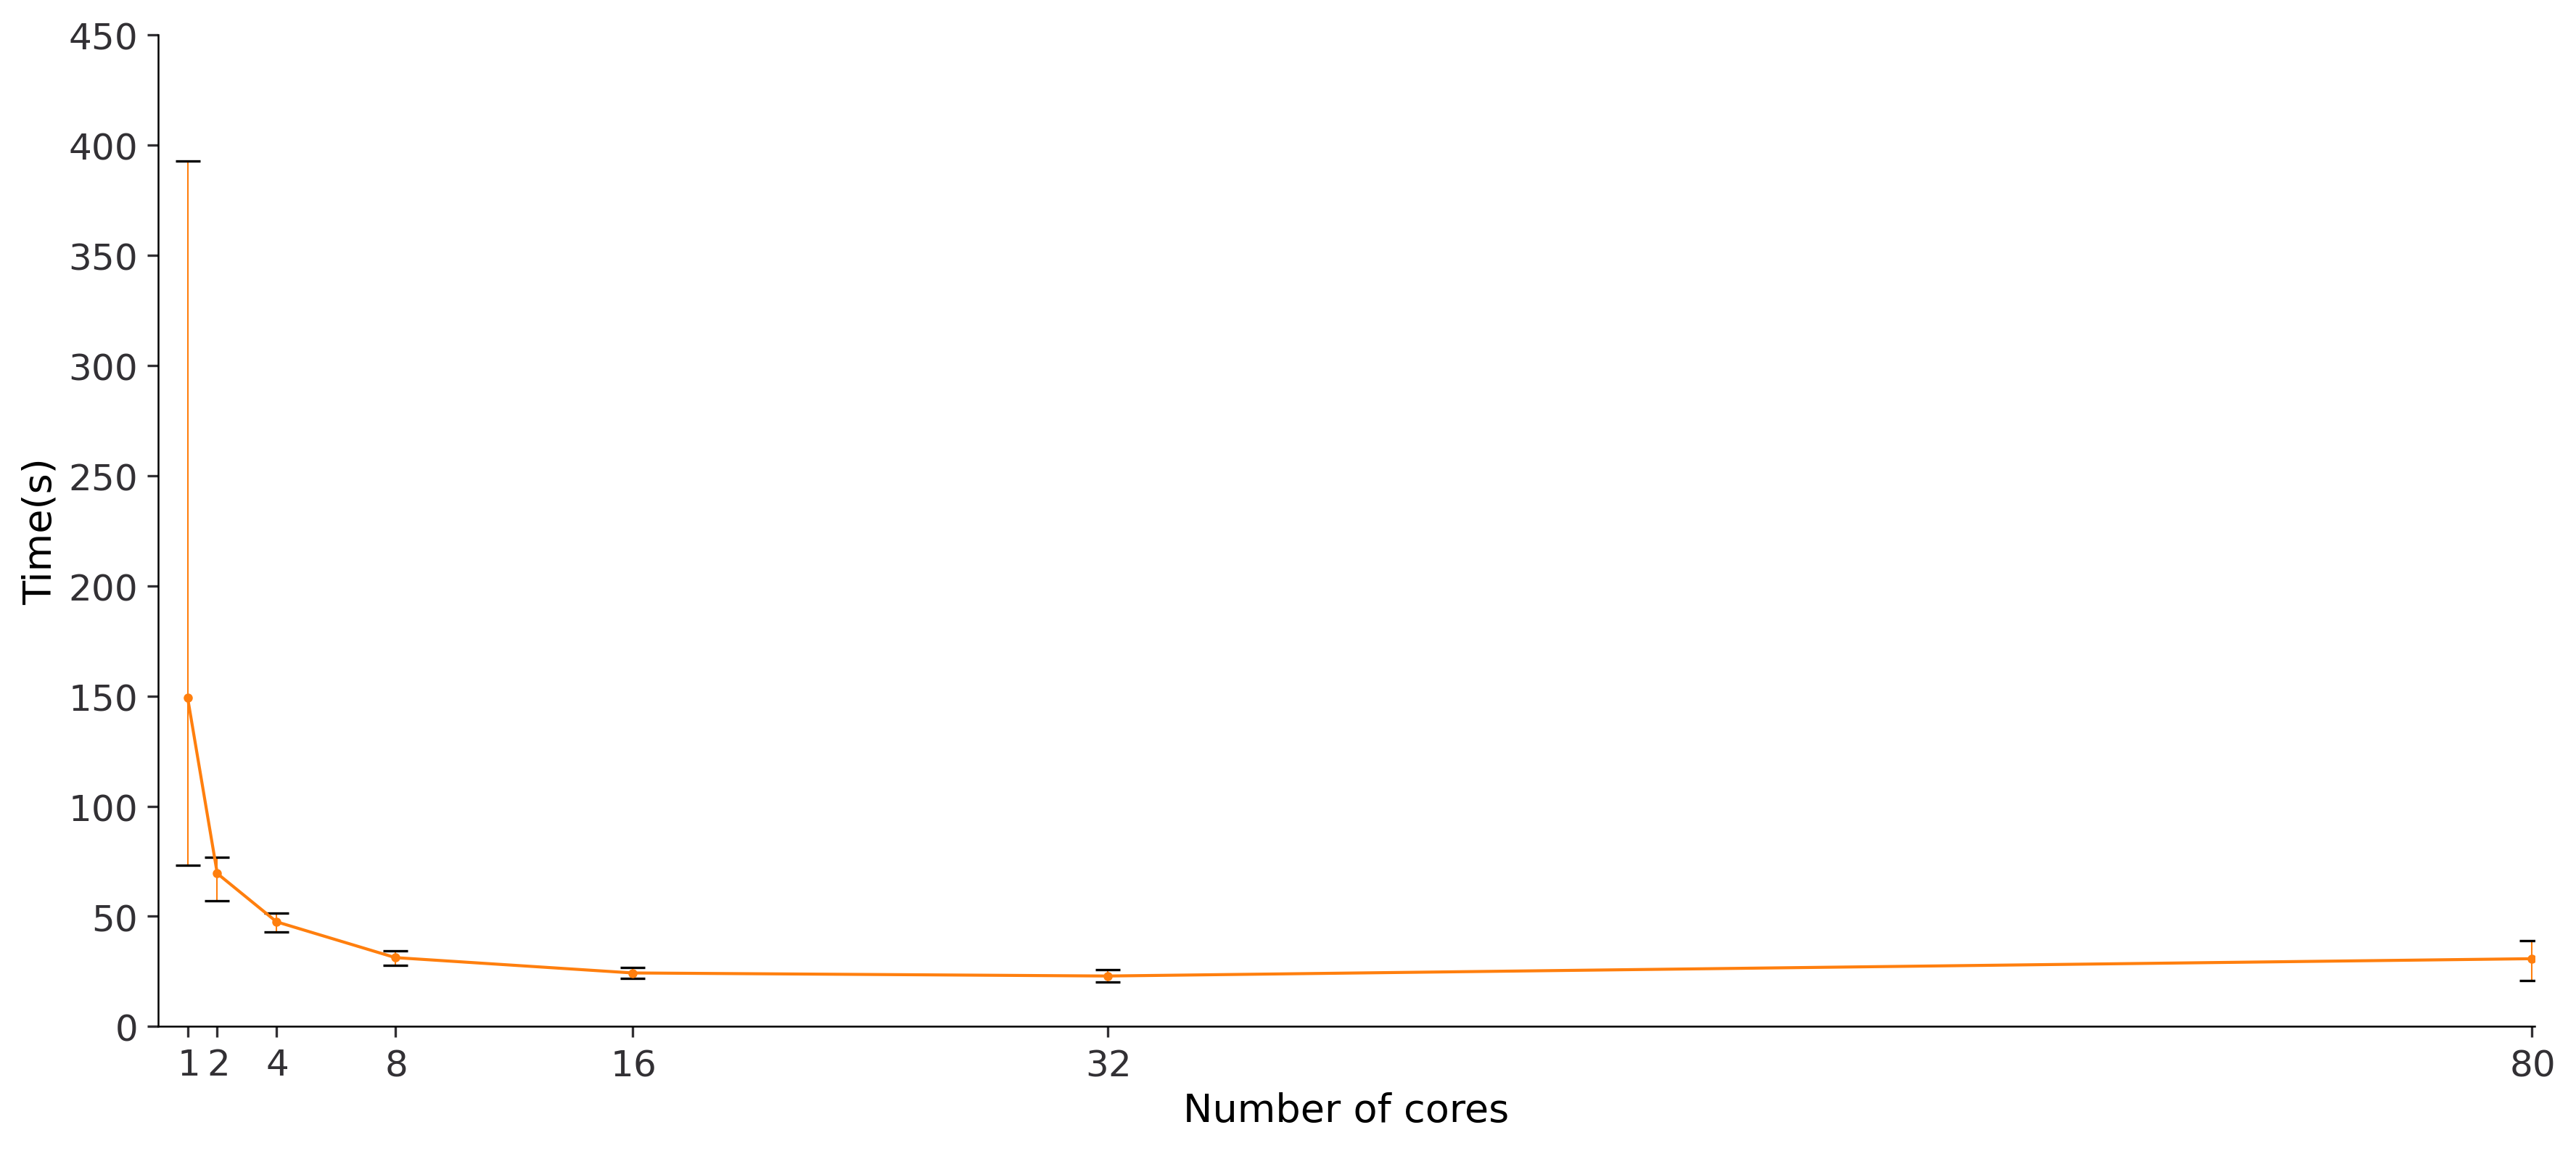

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('M3.csv', header=None)
data.columns = ["label", "core", "time"]

# Filter for 'time' and 'igap' measurement types
data['time'] /= 1000

# Group by dataset, Q value, measurement type, and hardness to compute mean and std
grouped_data = data.groupby(['label', 'core'])
sum_values = grouped_data['time'].sum().reset_index()
mean_values = grouped_data['time'].mean().reset_index()
min_values = grouped_data['time'].min().reset_index()
max_values = grouped_data['time'].max().reset_index()

# # Merge mean and std dataframes
aggregated_data = pd.merge(sum_values, mean_values, on=['label', 'core'])
aggregated_data = pd.merge(aggregated_data, min_values, on=['label', 'core'])
aggregated_data = pd.merge(aggregated_data, max_values, on=['label', 'core'])
aggregated_data.columns = ['label', 'core', 'sum', 'mean', 'min', 'max']
aggregated_data['ypos'] = aggregated_data['max']-aggregated_data['mean']
aggregated_data['yneg'] = aggregated_data['mean']-aggregated_data['min']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
xticks = [1,2,4,8,16,32,80]
ylims = [(0.1, 10), (0.1, 2)]

ax.errorbar(
    aggregated_data['core'], 
    aggregated_data['mean'], 
    yerr=[aggregated_data['yneg'], aggregated_data['ypos']],
    color=colorWheel[j],
    linestyle=linestyle,
    linewidth=lw,
    marker=marker,
    markersize=markersize,
    markeredgecolor=colorWheel[j],
    capsize=capsize,
    capthick=capthick,
    elinewidth=elinewidth,
    ecolor=colorWheel[j]
)
ax.set_xlim(0, 80.1)
ax.set_xticks(xticks)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Time(s)')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_3293709/1254340997.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


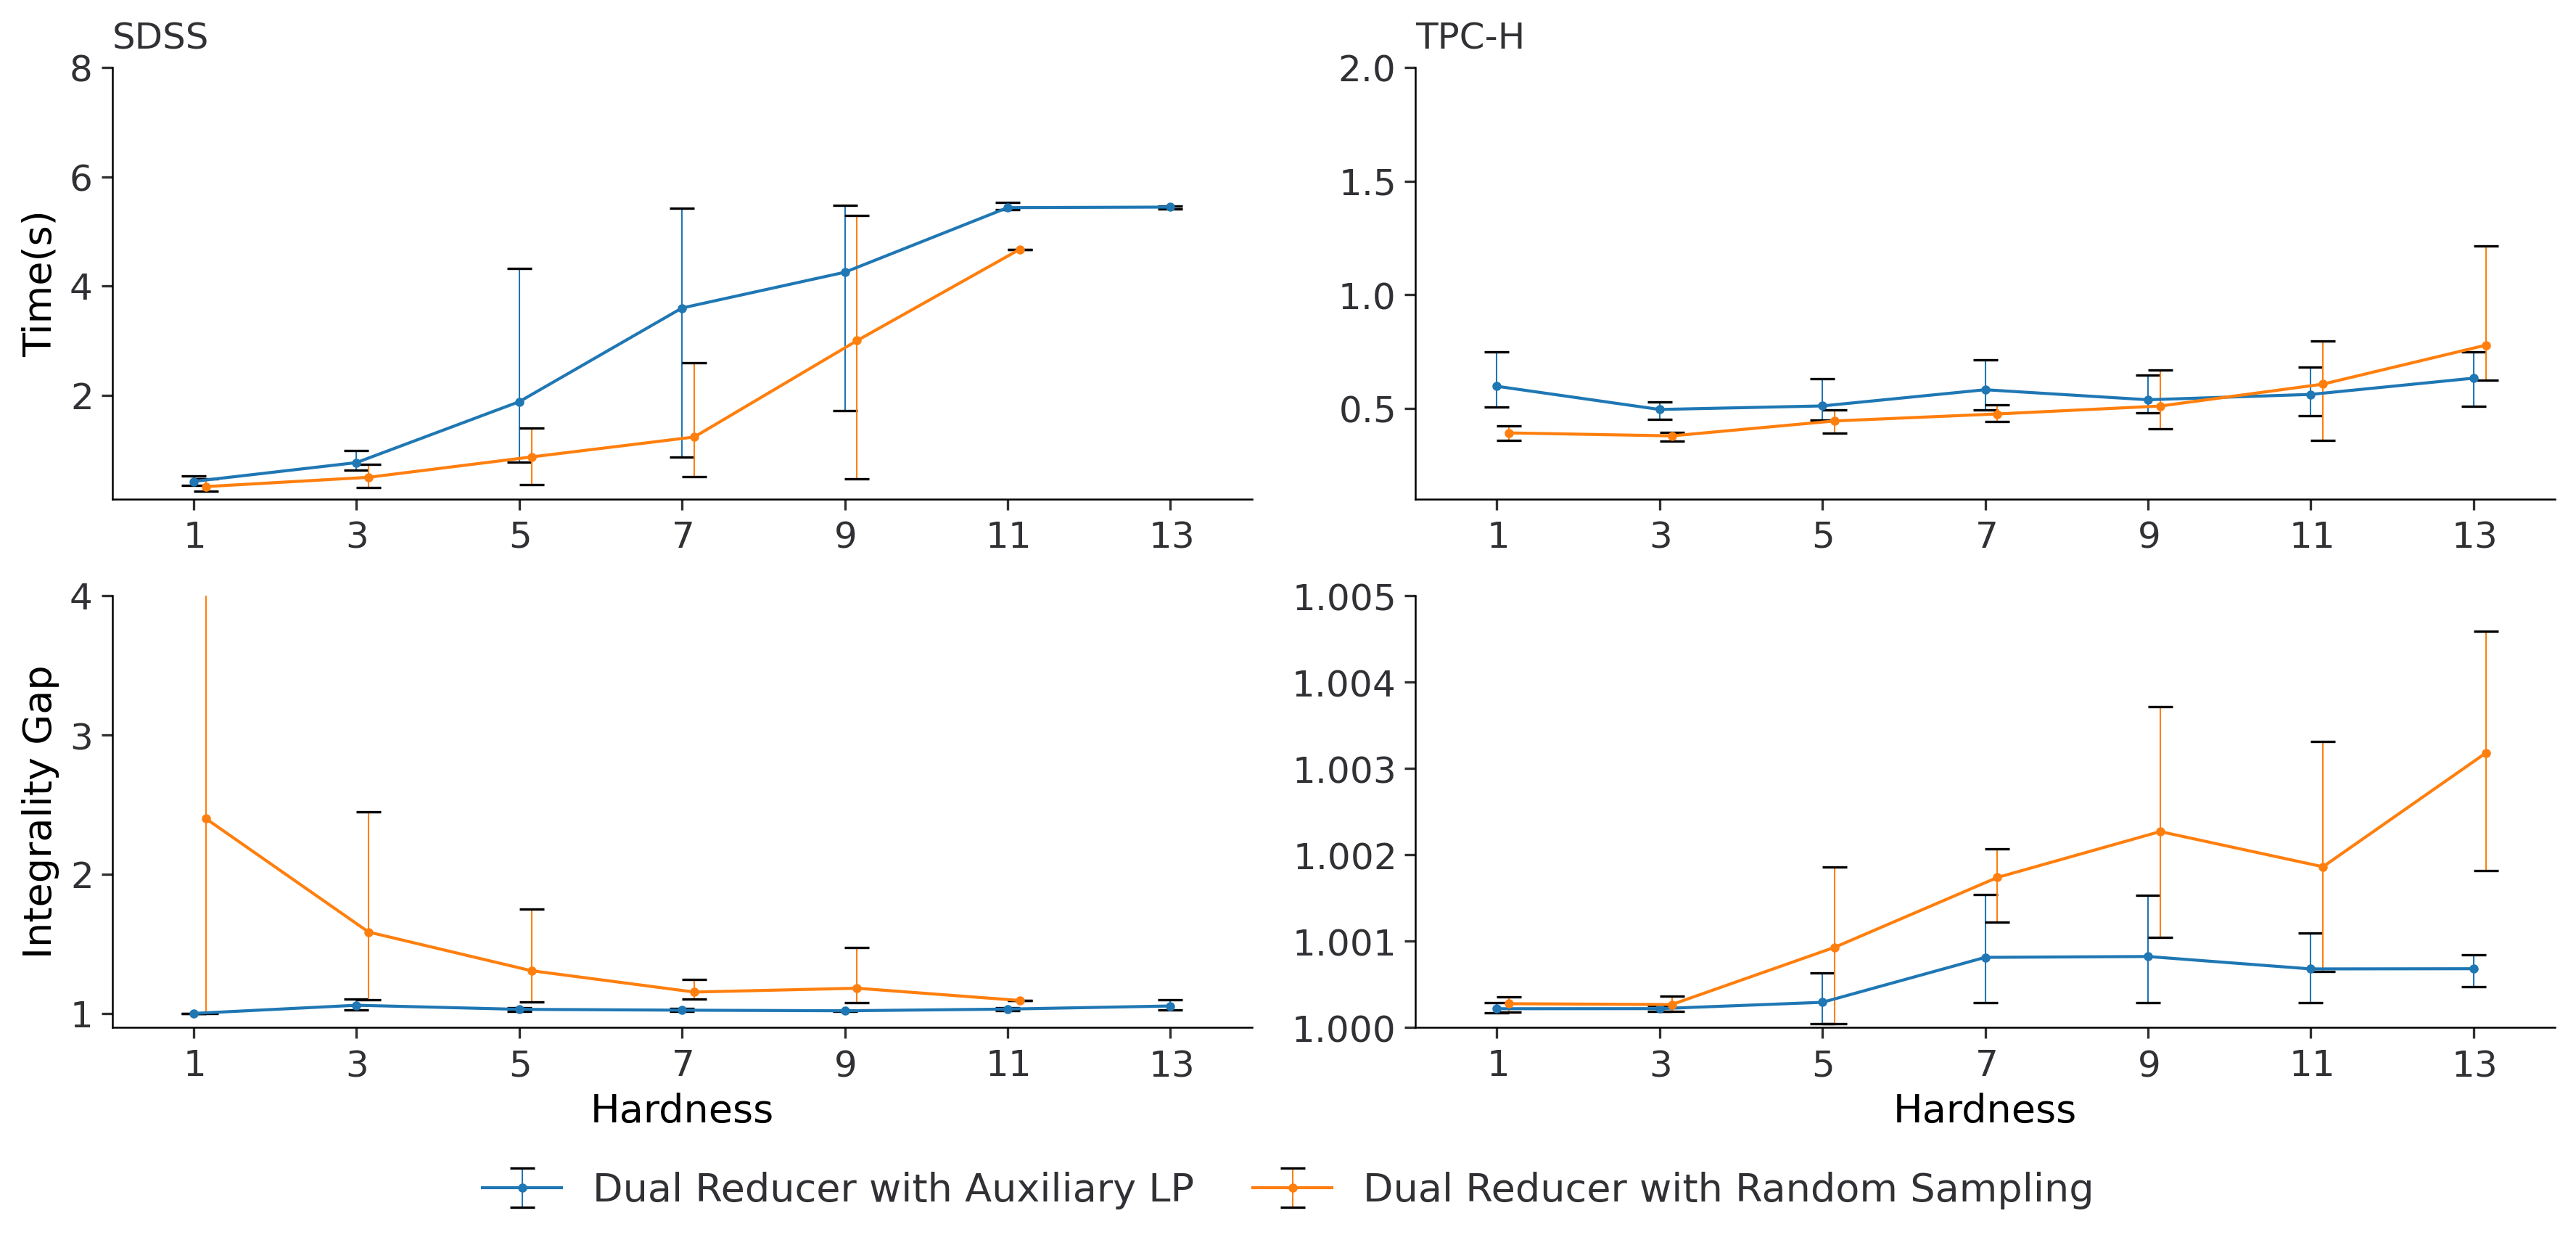

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('M4.csv', header=None)
data.columns = ["label", "hardness", "measurement_value"]

# Split label into dataset, Q value, and measurement type
data['dataset'] = data['label'].apply(lambda x: x.split('_')[0])
data['method'] = data['label'].apply(lambda x: x.split('_')[1])
data['measurement_type'] = data['label'].apply(lambda x: x.split('_')[2])

# Filter for 'time' and 'igap' measurement types
filtered_data = data[data['measurement_type'].isin(['time', 'igap', 'found', 'nofound'])]
filtered_data.loc[filtered_data['measurement_type'] == 'time', 'measurement_value'] /= 1000

# Group by dataset, Q value, measurement type, and hardness to compute mean and std
grouped_data = filtered_data.groupby(['dataset', 'method', 'measurement_type', 'hardness'])
sum_values = grouped_data['measurement_value'].sum().reset_index()
mean_values = grouped_data['measurement_value'].mean().reset_index()
min_values = grouped_data['measurement_value'].min().reset_index()
max_values = grouped_data['measurement_value'].max().reset_index()

# # Merge mean and std dataframes
aggregated_data = pd.merge(sum_values, mean_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, min_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, max_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data.columns = ['dataset', 'method', 'measurement_type', 'hardness', 'sum', 'mean', 'min', 'max']
aggregated_data['ypos'] = aggregated_data['max']-aggregated_data['mean']
aggregated_data['yneg'] = aggregated_data['mean']-aggregated_data['min']

# solved_problems = aggregated_data[aggregated_data['measurement_type'] == 'found'].groupby(['dataset', 'q']).agg({'sum': 'sum'}).rename(columns={'sum': 'solved'})
# print(solved_problems)
# # Merge the data to have both solved and total problems in one DataFrame
# problems_data = pd.merge(solved_problems, total_problems, on=['dataset_name', 'downscale', 'alpha']).reset_index()
# problems_data['solved_ratio'] = problems_data['solved'].astype(int).astype(str) + "/" + problems_data['total'].astype(int).astype(str)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
xticks = list(range(1, 14, 2))
dataset = ['ssds', 'tpch']
dataset_names = ['SDSS', 'TPC-H']
qs = ["DR", "RDR"]
d = 0.15
xoffset = np.arange(0, 5*d, d)
ylims = [(0.1, 8), (0.1, 2)]
ylimss = [(0.9, 4), (1, 1.005)]

for i, D in enumerate(dataset):
    df_agg = aggregated_data[aggregated_data['dataset']==D]
    ax = axs[0, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        time_data = q_data.loc[q_data['measurement_type']=='time']
#         print(time_data)
        ax.errorbar(
            time_data['hardness']+xoffset[j], 
            time_data['mean'], 
            yerr=[time_data['yneg'], time_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.set_xticks(xticks)
    ax.set_title(dataset_names[i])

    axx = axs[1, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        igap_data = q_data.loc[q_data['measurement_type']=='igap']
#         print(time_data)
        axx.errorbar(
            igap_data['hardness']+xoffset[j], 
            igap_data['mean'], 
            yerr=[igap_data['yneg'], igap_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    axx.set_ylim(ylimss[i][0], ylimss[i][1])
    axx.set_xticks(xticks)
    axx.set_xlabel('Hardness')

axs[0, 0].set_ylabel('Time(s)')
axs[1, 0].set_ylabel('Integrality Gap')

# Create a separate axis for the legend at the bottom
ax_leg = fig.add_axes([0.15, 0.05, 0.7, 0.05])
ax_leg.axis('off')

legends = ["Dual Reducer with Auxiliary LP", "Dual Reducer with Random Sampling"]

ax_leg.legend(axs[1, 1].get_legend_handles_labels()[0], [f"{legends[i]}" for i in range(len(qs))], loc='center', ncol=len(qs), frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()

In [17]:
with open("M5.csv", 'r') as file:
    vals = []
    for line in file:
        vals.append(int(float(line.split(',')[-1])/1000))
print(f"KD-Tree partitions a relation with 100 million tuples in {vals[0]}s")
print(f"DLV partitions a relation with 100 million tuples in {vals[1]}s")
print(f"DLV partitions a relation with 1 billion tuples in {vals[2]}s")

KD-Tree partitions a relation with 100 million tuples in 306s
DLV partitions a relation with 100 million tuples in 129s
DLV partitions a relation with 1 billion tuples in 1707s


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_3293709/3797099075.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


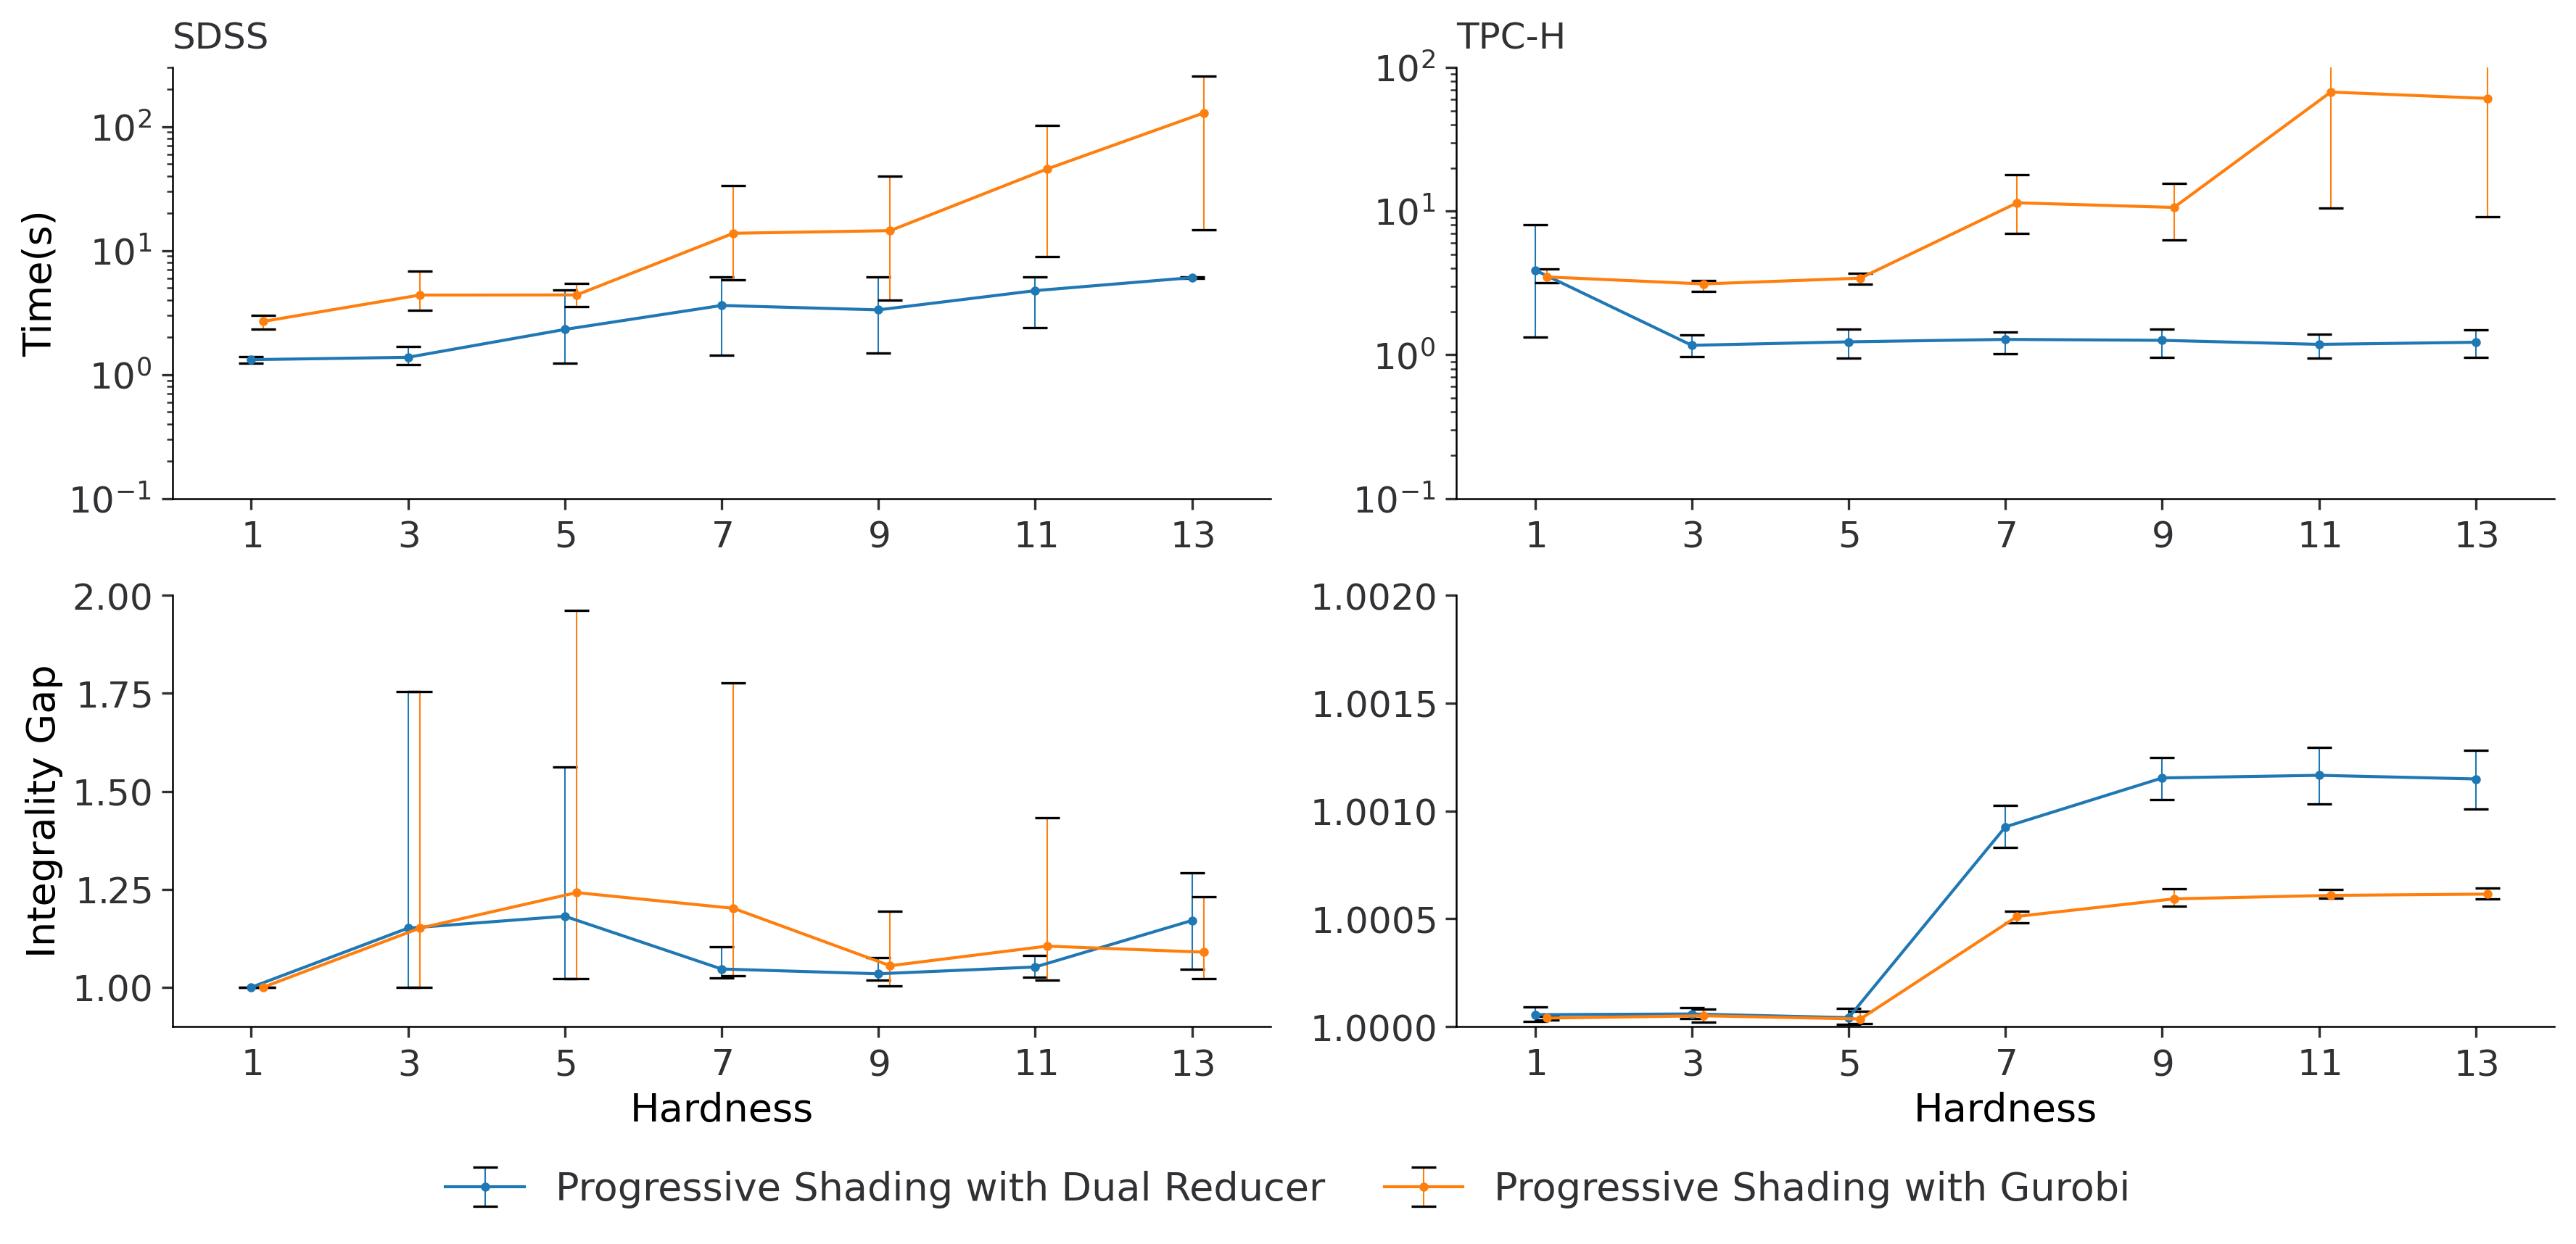

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('M6.csv', header=None)
data.columns = ["label", "hardness", "measurement_value"]

# Split label into dataset, Q value, and measurement type
data['dataset'] = data['label'].apply(lambda x: x.split('_')[0])
data['method'] = data['label'].apply(lambda x: x.split('_')[1])
data['measurement_type'] = data['label'].apply(lambda x: x.split('_')[2])

# Filter for 'time' and 'igap' measurement types
filtered_data = data[data['measurement_type'].isin(['time', 'igap', 'found', 'nofound'])]
filtered_data.loc[filtered_data['measurement_type'] == 'time', 'measurement_value'] /= 1000

# Group by dataset, Q value, measurement type, and hardness to compute mean and std
grouped_data = filtered_data.groupby(['dataset', 'method', 'measurement_type', 'hardness'])
sum_values = grouped_data['measurement_value'].sum().reset_index()
mean_values = grouped_data['measurement_value'].mean().reset_index()
min_values = grouped_data['measurement_value'].min().reset_index()
max_values = grouped_data['measurement_value'].max().reset_index()

# # Merge mean and std dataframes
aggregated_data = pd.merge(sum_values, mean_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, min_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data = pd.merge(aggregated_data, max_values, on=['dataset', 'method', 'measurement_type', 'hardness'])
aggregated_data.columns = ['dataset', 'method', 'measurement_type', 'hardness', 'sum', 'mean', 'min', 'max']
aggregated_data['ypos'] = aggregated_data['max']-aggregated_data['mean']
aggregated_data['yneg'] = aggregated_data['mean']-aggregated_data['min']

# solved_problems = aggregated_data[aggregated_data['measurement_type'] == 'found'].groupby(['dataset', 'q']).agg({'sum': 'sum'}).rename(columns={'sum': 'solved'})
# print(solved_problems)
# # Merge the data to have both solved and total problems in one DataFrame
# problems_data = pd.merge(solved_problems, total_problems, on=['dataset_name', 'downscale', 'alpha']).reset_index()
# problems_data['solved_ratio'] = problems_data['solved'].astype(int).astype(str) + "/" + problems_data['total'].astype(int).astype(str)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
xticks = list(range(1, 14, 2))
dataset = ['ssds', 'tpch']
dataset_names = ['SDSS', 'TPC-H']
qs = ["LSR", "GDRLSR"]
d = 0.15
xoffset = np.arange(0, 5*d, d)
ylims = [(0.1, 300), (0.1, 100)]
ylimss = [(0.9, 2), (1, 1.002)]

for i, D in enumerate(dataset):
    df_agg = aggregated_data[aggregated_data['dataset']==D]
    ax = axs[0, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        time_data = q_data.loc[q_data['measurement_type']=='time']
#         print(time_data)
        ax.errorbar(
            time_data['hardness']+xoffset[j], 
            time_data['mean'], 
            yerr=[time_data['yneg'], time_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    ax.set_yscale('log')
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.set_xticks(xticks)
    ax.set_title(dataset_names[i])

    axx = axs[1, i]
    for j, q in enumerate(qs):
        q_data = df_agg.loc[df_agg['method']==q] 
        igap_data = q_data.loc[q_data['measurement_type']=='igap']
#         print(time_data)
        axx.errorbar(
            igap_data['hardness']+xoffset[j], 
            igap_data['mean'], 
            yerr=[igap_data['yneg'], igap_data['ypos']],
            color=colorWheel[j],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[j],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[j],
            label=f'q={q}'
        )
    axx.set_ylim(ylimss[i][0], ylimss[i][1])
    axx.set_xticks(xticks)
    axx.set_xlabel('Hardness')

axs[0, 0].set_ylabel('Time(s)')
axs[1, 0].set_ylabel('Integrality Gap')

# Create a separate axis for the legend at the bottom
ax_leg = fig.add_axes([0.15, 0.05, 0.7, 0.05])
ax_leg.axis('off')

legends = ["Progressive Shading with Dual Reducer", "Progressive Shading with Gurobi"]

ax_leg.legend(axs[1, 1].get_legend_handles_labels()[0], [f"{legends[i]}" for i in range(len(qs))], loc='center', ncol=len(qs), frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()

/tmp/ipykernel_3293709/2178022468.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


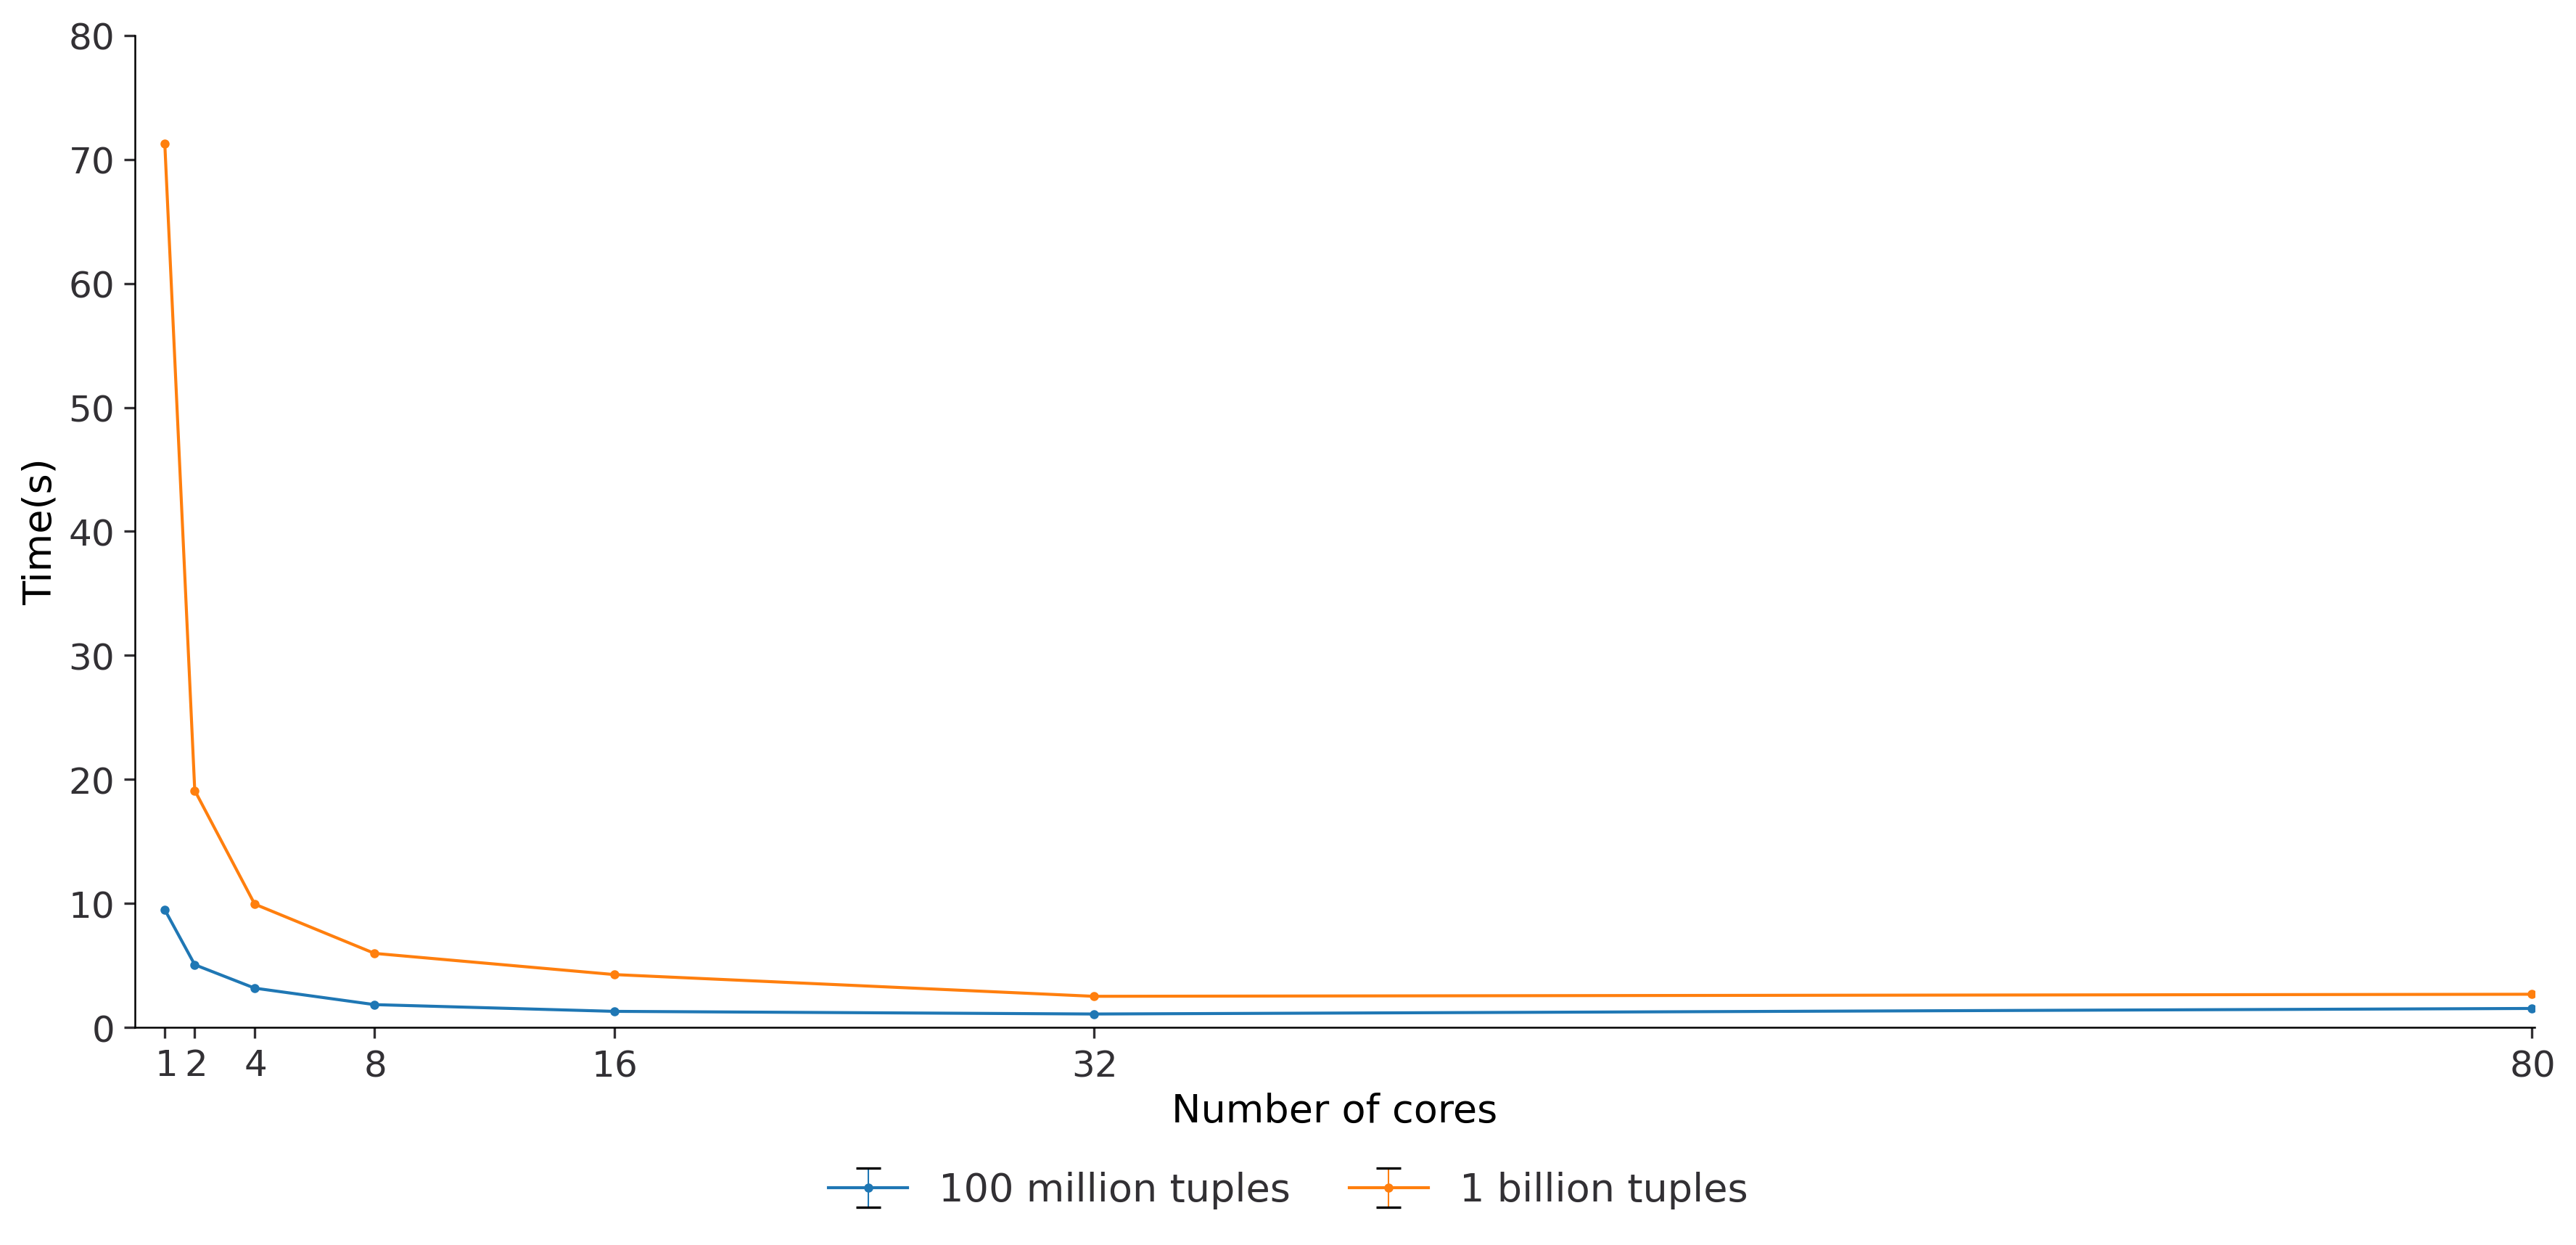

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

d = 0
SMALL_SIZE = 12+d
MEDIUM_SIZE = 13+d
BIGGER_SIZE = 16+d

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#markers = ['o', 'P', 'd', 'v', '^']

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('M7.csv', header=None)
data.columns = ["label", "core", "time"]

data['method'] = data['label'].apply(lambda x: x.split('_')[0])
data['measurement_type'] = data['label'].apply(lambda x: x.split('_')[1])

# Filter for 'time' and 'igap' measurement types
data['time'] /= 1000
qs = ["o8", "o9"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
xticks = [1,2,4,8,16,32,80]
ylims = [(0.1, 10), (0.1, 2)]

labels = ["100 million tuples", "1 billion tuples"]

for i, q in enumerate(qs): 
    ax.plot(
        data.loc[data['method']==q,'core'],
        data.loc[data['method']==q,'time'],
        color = colorWheel[i],
        linestyle=linestyle,
        lw=lw,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[i],
        label = labels[i]
    )
ax.set_xlim(0, 80.1)
ax.set_ylim(0, 80)
ax.set_xticks(xticks)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Time(s)')

# Create a separate axis for the legend at the bottom
ax_leg = fig.add_axes([0.15, 0.05, 0.7, 0.05])
ax_leg.axis('off')

ax_leg.legend(axs[1, 1].get_legend_handles_labels()[0], [f"{labels[i]}" for i in range(len(qs))], loc='center', ncol=len(qs), frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()